In [1]:
using Random
using Statistics
using Distributions
using ShiftedArrays
using CategoricalArrays
# using StatsPlots
using HypothesisTests

using DataFrames
using DataFramesMeta
using SpecialFunctions
using LinearAlgebra
using StatsFuns
using MixedModels
using CodecZlib
using JLD2
using Serialization
using LaTeXStrings
using ShiftedArrays: lag
using Latexify
using Markdown

using Revise

using CairoMakie  
# CairoMakie.activate!(inline=true)
CairoMakie.activate!(type = "png", inline=true, px_per_unit=2.0, pt_per_unit=1.0)

In [2]:
using RLSR  # Needed for simulation
using EM
base_dir = ".."
results_dir = "$(base_dir)/results"
output_dir = "output"
include("$(base_dir)/code/em_scripts.jl")
include("$(base_dir)/code/sailing_base_mbsr_blockwise_betas_twotd.jl")
# include("$(base_dir)/code/switch_counts.jl")
include("$(base_dir)/code/regression_sim.jl")
;

## Can skip if not plotting

In [3]:
function get_coefs(model, names)
    try
        name_subset = [n for n in names if n in unique(model.Name)]
        if length(name_subset) == 0
            return nothing
        end
        all_inds = [findfirst(model.Name .== name) for name in name_subset]
        coefs = model[all_inds, "Coef."]
        stderrs = model[all_inds, "Std. Error"]
        pvals = model[all_inds, "Pr(>|z|)"]
        return (coefs, stderrs, pvals, name_subset)
    catch
        return nothing
    end
end

get_coefs (generic function with 1 method)

In [4]:
set_theme!()
update_theme!(
        fontsize = 9,
        fonts = (; regular= "Helvetica", bold="Helvetica Bold"),
        # figure_padding = (12.0, 12.0, 15.0, 12.0),
        # figure_padding = (10.0, 10.0, 10.0, 10.0),
        figure_padding = (5.0, 5.0, 5.0, 5.0),
        Lines = (
            linewidth = 1.0,
        )
    )


In [5]:
file_prefix = "blockwise"
full_df = load("../derived/$(file_prefix).jld2")["full_df"]
ntrials = maximum(full_df.trial)
full_df[1:5, :]

Row,state1,state2,state3,endState,endBranchLeft,reward,action1Left,action2Left,rewardₜ₋₁,rewardₜ₋₂,state1ₜ₋₁,state1ₜ₋₂,state1ₜ₋₃,state2ₜ₋₁,state2ₜ₋₂,state3ₜ₋₁,state3ₜ₋₂,endStateₜ₋₁,endStateₜ₋₂,endBranchLeftₜ₋₁,endBranchLeftₜ₋₂,trial,subject,action1TowardsPrevEnd,action1Persistance,endBranchₜ₋₁SameAsLastChoice,priorMoveAt1,priorMoveAt2,priorMoveAt3,parentPriorMove,parentPriorMoveToEndState,parentPriorMoveToEndStateₜ₋₁,priorRewardAt2,priorRewardAt3,priorRewardAt4,priorRewardAt5,priorRewardAt6,priorRewardAt7,endStateSiblingPriorReward,endStateSiblingPriorRewardₜ₋₁,endStatePriorReward,endStatePriorRewardₜ₋₁,endStatePriorRewardₜ₋₂,priorRewardLeftBranch,priorRewardRightBranch,endStateBranchPriorReward,endStateBranchPriorRewardₜ₋₁,endStateBranchPriorRewardₜ₋₂,sub,assignment,r1,r2,r3,r4,rt_boat,rt_island,rewscaled,rwd_swap,rwd_swap_type,block_ind,block_num
,Int64,Int64,Int64,Int64,Bool,Float64,Bool?,Bool?,Float64?,Float64?,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,Bool?,Bool?,Int64,String,Bool?,Bool?,Bool?,Int64?,Int64?,Int64?,Int64?,Bool?,Bool?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Int64,String,Float64,Float64,Float64,Float64,Real,Union…,Float64,Bool,String,Int64,Int64
1,1,3,6,6,false,0.0,false,true,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,1,001,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,1,02nzj9jkf5f6zt1qpj88npr9,0.675,0.325,0.15,0.85,31.6,1743.3,-1.0,false,start,0,0
2,4,-1,-1,4,true,1.0,missing,missing,0.0,missing,1,missing,missing,3,missing,6,missing,6,missing,false,missing,2,001,missing,missing,missing,3,missing,6,missing,missing,missing,missing,missing,missing,missing,0.0,missing,missing,missing,missing,missing,missing,missing,0.0,missing,missing,missing,1,02nzj9jkf5f6zt1qpj88npr9,0.675,0.325,0.15,0.85,3324.2,,1.0,false,start,1,0
3,1,2,4,4,true,1.0,true,true,1.0,0.0,4,1,missing,missing,3,missing,6,4,6,true,false,3,001,true,false,false,3,missing,6,missing,missing,missing,missing,missing,1.0,missing,0.0,missing,missing,missing,1.0,missing,missing,1.0,0.0,1.0,missing,missing,1,02nzj9jkf5f6zt1qpj88npr9,0.675,0.325,0.15,0.85,1050.3,967,1.0,false,start,2,0
4,7,-1,-1,7,false,1.0,missing,missing,1.0,1.0,1,4,1,2,missing,4,missing,4,4,true,true,4,001,missing,missing,true,2,4,6,6,false,missing,missing,missing,1.0,missing,0.0,missing,0.0,missing,missing,1.0,missing,1.0,0.0,0.0,1.0,missing,1,02nzj9jkf5f6zt1qpj88npr9,0.675,0.325,0.15,0.85,2148.6,,1.0,false,start,3,0
5,1,2,4,4,true,1.0,true,true,1.0,1.0,7,1,4,missing,2,missing,4,7,4,false,true,5,001,false,true,false,2,4,6,4,true,false,missing,missing,1.0,missing,0.0,1.0,missing,0.0,1.0,missing,1.0,1.0,1.0,1.0,0.0,1.0,1,02nzj9jkf5f6zt1qpj88npr9,0.675,0.325,0.15,0.85,841.6,1189.4,1.0,false,start,4,0


In [6]:
findall(.!ismissing.(full_df.rewardₜ₋₁) .& (full_df.rewardₜ₋₁ .== 1.0))

22840-element Vector{Int64}:
     3
     4
     5
     6
    11
    16
    17
    20
    21
    22
     ⋮
 39940
 39942
 39944
 39945
 39946
 39947
 39949
 39950
 39952

In [7]:
avgs_rwd = zeros(100)
avgs_norwd = zeros(100)
for s in 1:100
    x = full_df[findall((full_df.sub .== s) .& .!ismissing.(full_df.rewardₜ₋₁) .& .!ismissing.(full_df.action1TowardsPrevEnd) .& (full_df.rewardₜ₋₁ .== 1.0)), :action1TowardsPrevEnd]
    avgs_rwd[s] = mean(x)
    x = full_df[findall((full_df.sub .== s) .& .!ismissing.(full_df.rewardₜ₋₁) .& .!ismissing.(full_df.action1TowardsPrevEnd) .& (full_df.rewardₜ₋₁ .== 0.0)), :action1TowardsPrevEnd]
    avgs_norwd[s] = mean(x)
end

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /Users/abizzle/.julia/packages/Makie/FUAHr/src/scenes.jl:238


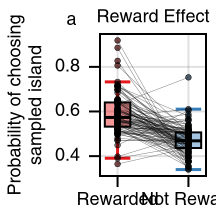

In [8]:
f = Figure(resolution=72 .* (1.5, 1.5))
colors = categorical_colors(:Set1, 4)
ax1 = Axis(f[1,1], xticks = (1:2, ["Rewarded", "Not Reward"]),
    ylabel="Probability of choosing\nsampled island",
    palette = (; patchcolor = colors),
    title = "Reward Effect",
)
Label(f[1, 1, TopLeft()], "a", fontsize = 9, font = :bold, padding = (0, 12, 2, 0), halign = :right)
boxplot!(repeat([1], inner=100), avgs_rwd,
        whiskerwidth = 1.0, whiskercolor = (colors[1], 1),
        strokecolor = :black, strokewidth = 1,
        color=(colors[1], 0.45),
        width=0.45,
        markersize=4,
)
boxplot!(repeat([2], inner=100), avgs_norwd,
        whiskerwidth = 1.0, whiskercolor = (colors[2], 1),
        strokecolor = :black, strokewidth = 1,
        color=(colors[2], 0.45),
        width=0.45,
        markersize=4,
)
for i in 1:100
    lines!([1, 2], [avgs_rwd[i], avgs_norwd[i]], color=(:black, 0.5), linewidth=0.25)
    scatter!([1, 2], [avgs_rwd[i], avgs_norwd[i]], color=(:black, 0.5), strokewidth=0.25, markersize=4)
end

# save("figures/reward_effect.pdf", f, pt_per_unit=1.0)
f

## Simulations

A few simulations to choose reasonable parameters for simulation

In [ ]:
ver = "betas_twotd_BSR1_BBoat_a1_aM1_islandbias_boatbias_homeaway_rewscaled_initx-100"
RERUN = true
if RERUN
    extended = true  # Estimate SEs etc. on parameters
    threads = true
    rewscaled = true
    groups = nothing
    initx = true  # Simulate multiple starting points
    nstarts = 100
    decorrelateαβ = false
    full = false
    add_betas = false

    # Whether to fit the following as free parameters
    add_TDλ1 = false  # Assuming TD1, not fitting λ
    add_TDλ2 = false
    add_βTD_1 = false
    add_βTD_2 = false
    add_βMB1 = false
    add_βMB2 = false
    add_βSR1 = true
    add_βSR2 = false
    add_βBoat = true
    add_α1 = true
    add_α2 = false  # Split-Block Reward learning rate
    add_αM1 = true
    add_αM2 = false  # Split-Block SR learning rate
    add_initial_V = false  # Initial V as free paramter

    add_decay = false
    separate_decay = false
    add_island_stay_bias = true
    add_boat_stay_bias = true
    separate_home_away = true  # Separate learning rates for passive / traversal trials

    # Default values don't really matter here for anything being fit
    TDλ1 = nothing
    TDλ2 = nothing
    βTD_1 = nothing
    βTD_2 = nothing
    βMB1 = nothing
    βMB2 = nothing
    βSR1 = nothing
    βSR2 = nothing
    βBoat = nothing
    α1Home = nothing
    α1Away = nothing
    α2Home = nothing
    α2Away = nothing
    αM1 = nothing
    αM2 = nothing
    r_BSR1_homeaway = run_tdλ_mb_sr_blockwise_twotd(full_df; extended, threads, rewscaled, groups, initx, decorrelateαβ, full, add_betas,
        add_TDλ1, add_TDλ2, add_βTD_1, add_βTD_2, add_βMB1, add_βMB2, add_βSR1, add_βSR2, add_βBoat, add_α1, add_α2, add_αM1, add_αM2, add_initial_V,
        add_decay, separate_decay, add_island_stay_bias, add_boat_stay_bias, separate_home_away,
        TDλ1, TDλ2, βTD_1, βTD_2, βMB1, βMB2, βSR1, βSR2, βBoat, α1Home, α1Away, α2Home, α2Away, αM1, αM2,
        nstarts,
    )
    save("../results/modelfits/$(ver).jld2", "results", r_BSR1_homeaway)
end

varnames = ["βSR1", "βBoat", "island_stay_bias", "boat_stay_bias", "α1Home", "α1Away", "αM1"]
initbetas = [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
initsigma = [5.0, 5.0, 5.0, 5.0, 1.0, 1.0, 1.0]
X = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

iter: 9
betas: [2.14 2.17 0.45 0.27 -0.71 0.35 -0.51]
sigma: [2.23, 1.8, 0.56, 0.27, 0.96, 0.52, 0.91]
free energy: -17189.551735
change: [2.9e-5, 0.0, 4.0e-6, 0.000168, -2.2e-5, 6.4e-5, -0.000215, 0.000103, 4.0e-6, 1.4e-5, 0.00069, 1.5e-5, 4.6e-5, 0.00034]
max: 0.00069


┌ Info: Running emerrors
└ @ Main /Users/arik/Library/CloudStorage/Dropbox/Princeton/SR_Paper/code/sailing_base_mbsr_blockwise_betas_twotd.jl:696


In [ ]:
ver = "betas_twotd_BMB1_BBoat_a1_islandbias_boatbias_homeaway_rewscaled_initx-100"
RERUN = true
if RERUN
    extended = true  # Estimate SEs etc. on parameters
    threads = true
    rewscaled = true
    groups = nothing
    initx = true  # Simulate multiple starting points
    nstarts = 100
    decorrelateαβ = false
    full = false
    add_betas = false

    # Whether to fit the following as free parameters
    add_TDλ1 = false  # Assuming TD1, not fitting λ
    add_TDλ2 = false
    add_βTD_1 = false
    add_βTD_2 = false
    add_βMB1 = true
    add_βMB2 = false
    add_βSR1 = false
    add_βSR2 = false
    add_βBoat = true
    add_α1 = true
    add_α2 = false  # Split-Block Reward learning rate
    add_αM1 = false
    add_αM2 = false  # Split-Block SR learning rate
    add_initial_V = false  # Initial V as free paramter

    add_decay = false
    separate_decay = false
    add_island_stay_bias = true
    add_boat_stay_bias = true
    separate_home_away = true  # Separate learning rates for passive / traversal trials

    # Default values don't really matter here for anything being fit
    TDλ1 = nothing
    TDλ2 = nothing
    βTD_1 = nothing
    βTD_2 = nothing
    βMB1 = nothing
    βMB2 = nothing
    βSR1 = nothing
    βSR2 = nothing
    βBoat = nothing
    α1Home = nothing
    α1Away = nothing
    α2Home = nothing
    α2Away = nothing
    αM1 = nothing
    αM2 = nothing
    r_BMB1_homeaway = run_tdλ_mb_sr_blockwise_twotd(full_df; extended, threads, rewscaled, groups, initx, decorrelateαβ, full, add_betas,
        add_TDλ1, add_TDλ2, add_βTD_1, add_βTD_2, add_βMB1, add_βMB2, add_βSR1, add_βSR2, add_βBoat, add_α1, add_α2, add_αM1, add_αM2, add_initial_V,
        add_decay, separate_decay, add_island_stay_bias, add_boat_stay_bias, separate_home_away,
        TDλ1, TDλ2, βTD_1, βTD_2, βMB1, βMB2, βSR1, βSR2, βBoat, α1Home, α1Away, α2Home, α2Away, αM1, αM2,
        nstarts,
    )
    save("../results/modelfits/$(ver).jld2", "results", r_BMB1_homeaway)
end

varnames = ["βMB1", "βBoat", "island_stay_bias", "boat_stay_bias", "α1Home", "α1Away"]
initbetas = [1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
initsigma = [5.0, 5.0, 5.0, 5.0, 1.0, 1.0]
X = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

iter: 9
betas: [1.97 2.26 0.56 0.25 -0.72 0.21]
sigma: [1.8, 1.86, 0.67, 0.28, 0.91, 0.55]
free energy: -17126.633846
change: [9.2e-5, 4.4e-5, 3.6e-5, 6.3e-5, -7.0e-6, 3.1e-5, 0.000429, 0.000181, 3.5e-5, 0.000587, 6.3e-5, 0.000196]
max: 0.000587


┌ Info: Running emerrors
└ @ Main /Users/arik/Library/CloudStorage/Dropbox/Princeton/SR_Paper/code/sailing_base_mbsr_blockwise_betas_twotd.jl:696


In [ ]:
ver = "betas_twotd_BMB1_BSR1_BBoat_a1_aM1_islandbias_boatbias_homeaway_rewscaled_initx-100"
RERUN = true
if RERUN
    extended = true  # Estimate SEs etc. on parameters
    threads = true
    rewscaled = true
    groups = nothing
    initx = true  # Simulate multiple starting points
    nstarts = 100
    decorrelateαβ = false
    full = false
    add_betas = false

    # Whether to fit the following as free parameters
    add_TDλ1 = false  # Assuming TD1, not fitting λ
    add_TDλ2 = false
    add_βTD_1 = false
    add_βTD_2 = false
    add_βMB1 = true
    add_βMB2 = false
    add_βSR1 = true
    add_βSR2 = false
    add_βBoat = true
    add_α1 = true
    add_α2 = false  # Split-Block Reward learning rate
    add_αM1 = true
    add_αM2 = false  # Split-Block SR learning rate
    add_initial_V = false  # Initial V as free paramter

    add_decay = false
    separate_decay = false
    add_island_stay_bias = true
    add_boat_stay_bias = true
    separate_home_away = true  # Separate learning rates for passive / traversal trials

    # Default values don't really matter here for anything being fit
    TDλ1 = nothing
    TDλ2 = nothing
    βTD_1 = nothing
    βTD_2 = nothing
    βMB1 = nothing
    βMB2 = nothing
    βSR1 = nothing
    βSR2 = nothing
    βBoat = nothing
    α1Home = nothing
    α1Away = nothing
    α2Home = nothing
    α2Away = nothing
    αM1 = nothing
    αM2 = nothing
    r_BMB1_BSR1_homeaway = run_tdλ_mb_sr_blockwise_twotd(full_df; extended, threads, rewscaled, groups, initx, decorrelateαβ, full, add_betas,
        add_TDλ1, add_TDλ2, add_βTD_1, add_βTD_2, add_βMB1, add_βMB2, add_βSR1, add_βSR2, add_βBoat, add_α1, add_α2, add_αM1, add_αM2, add_initial_V,
        add_decay, separate_decay, add_island_stay_bias, add_boat_stay_bias, separate_home_away,
        TDλ1, TDλ2, βTD_1, βTD_2, βMB1, βMB2, βSR1, βSR2, βBoat, α1Home, α1Away, α2Home, α2Away, αM1, αM2,
        nstarts,
    )
    save("../results/modelfits/$(ver).jld2", "results", r_BMB1_BSR1_homeaway)
end

varnames = ["βMB1", "βSR1", "βBoat", "island_stay_bias", "boat_stay_bias", "α1Home", "α1Away", "αM1"]
initbetas = [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
initsigma = [5.0, 5.0, 5.0, 5.0, 5.0, 1.0, 1.0, 1.0]
X = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

iter: 10
betas: [0.92 1.22 2.15 0.46 0.28 -0.67 0.32 -0.35]
sigma: [1.04, 1.18, 1.74, 0.59, 0.27, 0.97, 0.5, 0.9]
free energy: -17091.199905
change: [0.000621, 0.000542, 0.000125, 0.000374, 0.000302, -0.000198, 0.000297, -0.001097, 0.003982, 0.003268, 0.000468, 0.000176, 5.2e-5, 0.0001

┌ Info: Running emerrors
└ @ Main /Users/arik/Library/CloudStorage/Dropbox/Princeton/SR_Paper/code/sailing_base_mbsr_blockwise_betas_twotd.jl:696


## Regression

### SR-IS

In [ ]:
function regression_sr_blockwise_cov_fixedalpha(centering, biastype, interactiontype, αHome, αAway; nsims=200, seed=nothing, use_sr_importance_sampling=true)
    suffix = "reg_sr-is_blockwise_cov_n-$(nsims)_aHome-$(αHome)_aAway-$(αAway)"
    if !isnothing(seed)
        Random.seed!(seed)
        suffix *= "_seed-$(seed)"
    end

    r = load("$(base_dir)/results/modelfits/betas_twotd_BSR1_BBoat_a1_aM1_islandbias_boatbias_homeaway_rewscaled_initx-100.jld2", "results")
    covm = sqrt(r.sigma)

    transformed_variance = covm[1,1] * (1/(r.betas[1])^2)^2
    
    dfs = []
    for s in 1:nsims
        βTD0 = 0.0
        βTD1 = 0.0
        βSR = rand(Normal(r.betas[1], covm[1,1]))
        βMB = 0.0
        βBoat = rand(Normal(r.betas[2], covm[2,2]))
        island_bias = rand(Normal(r.betas[3], covm[3,3]))
        boat_bias = rand(Normal(r.betas[4], covm[4,4]))
        αM = unitnorm(rand(Normal(r.betas[7], covm[7,7])))
        γ = 0.9
        c = 0.1
        # sr_λ = rand(Normal(1/(r.betas[1]), sqrt(transformed_variance)))
        # sr_λ = 1/abs(βSR)
        sr_λ = rand(Uniform(0.01, 0.2))
        df = sim_blockwise_TD0TD1SRMB_subject(βTD0, βTD1, βSR, βMB, βBoat, island_bias, boat_bias, αHome, αAway, αM, γ, s, use_sr_importance_sampling, sr_λ, c)
        df[!, "sub"] .= s
        df[!, "subject"] .= lpad(s, 3, "0")
        push!(dfs, df)
    end
    df_reg = vcat(dfs...)

    add_all_regressors!(df_reg)
    df_reg = filter_df(df_reg)
    (extra_suffix, center_fn, fm) = make_reg_suffix(centering, biastype, interactiontype)
    suffix *= extra_suffix
    df_reg = center_fn(df_reg)
    @info suffix
    flush(stdout)

    result_reg = fit(MixedModel, fm, df_reg, Binomial(), progress=false)
    save("$(results_dir)/regression4/$(suffix)_coeftable.jld2", "results", coeftable(result_reg); compress=true)
    result_reg
end
regression_sr_blockwise_cov_fixedalpha(:rwdchoice, :rwdonly, nothing, 0.5, 0.5; seed=0)
regression_sr_blockwise_cov_fixedalpha(:rwdchoice, :neighborboatlag5policylag5sameboatlag5, nothing, 0.5, 0.5; seed=0)
;

┌ Info: reg_sr-is_blockwise_cov_n-200_aHome-0.5_aAway-0.5_seed-0_center-rwd-choice_rwdonly
└ @ Main /Users/abizzle/Research/SR-IS/src/kahn-analysis/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:40
┌ Info: reg_sr-is_blockwise_cov_n-200_aHome-0.5_aAway-0.5_seed-0_center-rwd-choice_neighborboatlag5policylag5sameboatlag5
└ @ Main /Users/abizzle/Research/SR-IS/src/kahn-analysis/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:40


### Linear RL

In [ ]:
function regression_lrl_blockwise_cov_fixedalpha(centering, biastype, interactiontype, αHome, αAway; nsims=200, seed=nothing)
    suffix = "reg_lrl_blockwise_cov_n-$(nsims)_aHome-$(αHome)_aAway-$(αAway)"
    if !isnothing(seed)
        Random.seed!(seed)
        suffix *= "_seed-$(seed)"
    end

    # You'll need to either:
    # 1. Load fitted LRL parameters from a model fit file, or
    # 2. Set reasonable parameter values based on literature/pilot studies
    
    # Option 1: Load from fitted model (if you have LRL model fits)
    # r = load("$(base_dir)/results/modelfits/lrl_model_fits.jld2", "results")
    # covm = sqrt(r.sigma)
    
    # Option 2: Set reasonable parameter values manually
    # Based on typical LRL parameter ranges from literature
    mean_βLRL = 1.0        # Choice temperature for first-stage
    mean_βBoat = 1.0       # Choice temperature for second-stage  
    mean_α = 0.5           # Reward learning rate
    mean_αT = 0.5          # Transition learning rate
    mean_log_λ = -1.0      # Log eligibility trace (λ ≈ 0.37)
    
    # Standard deviations for parameter sampling
    σβLRL = 0.5
    σβBoat = 0.5
    σα = 0.2
    σαT = 0.2
    σlog_λ = 0.5
    
    c = 0.1  # Choice consistency parameter
    
    dfs = []
    for s in 1:nsims
        # Sample parameters from distributions
        s_βLRL = rand(Normal(mean_βLRL, σβLRL))
        s_βBoat = rand(Normal(mean_βBoat, σβBoat))
        s_α = unitnorm(rand(Normal(mean_α, σα)))
        s_αT = unitnorm(rand(Normal(mean_αT, σαT)))
        # s_log_λ = rand(Normal(mean_log_λ, σlog_λ))
        
        # Simulate using the existing LRL function
        df = sim_blockwise_LRL(
            βLRL=s_βLRL,
            βBoat=s_βBoat,
            # island_bias=0.0,     # Not used in the function
            # boat_bias=0.0,       # Not used in the function
            α=s_α,
            αT=s_αT,
            # s_λ = 0.1,
            # s_λ = 1.0,
            s_λ = rand(Uniform(0.01, 0.2)),
            # log_λ=s_log_λ,
            σβLRL=0.0,           # Set to 0 since we're sampling manually
            σβBoat=0.0,
            # σisland_bias=0.0,
            # σboat_bias=0.0,
            σα=0.0,
            σαT=0.0,
            # σlog_λ=0.0,
            c=c,
            nsims=1              # Only simulate 1 subject per call
        )
        # The sim_blockwise_LRL function returns multiple subjects, so extract the first one
        df_sub = df[df.sub .== 1, :]
        df_sub[!, "sub"] .= s
        df_sub[!, "subject"] .= lpad(s, 3, "0")
        push!(dfs, df_sub)
    end
    df_reg = vcat(dfs...)

    add_all_regressors!(df_reg)
    df_reg = filter_df(df_reg)
    (extra_suffix, center_fn, fm) = make_reg_suffix(centering, biastype, interactiontype)
    suffix *= extra_suffix
    df_reg = center_fn(df_reg)
    @info suffix
    flush(stdout)

    result_reg = fit(MixedModel, fm, df_reg, Binomial(), progress=false)
    save("$(results_dir)/regression4/$(suffix)_coeftable.jld2", "results", coeftable(result_reg); compress=true)
    result_reg
end

# Run the LRL simulations
regression_lrl_blockwise_cov_fixedalpha(:rwdchoice, :rwdonly, nothing, 0.5, 0.5; seed=0)
regression_lrl_blockwise_cov_fixedalpha(:rwdchoice, :neighborboatlag5policylag5sameboatlag5, nothing, 0.5, 0.5; seed=0)

┌ Info: reg_lrl_blockwise_cov_n-200_aHome-0.5_aAway-0.5_seed-0_center-rwd-choice_rwdonly
└ @ Main /Users/abizzle/Research/SR-IS/src/kahn-analysis/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X24sZmlsZQ==.jl:77
┌ Info: reg_lrl_blockwise_cov_n-200_aHome-0.5_aAway-0.5_seed-0_center-rwd-choice_neighborboatlag5policylag5sameboatlag5
└ @ Main /Users/abizzle/Research/SR-IS/src/kahn-analysis/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X24sZmlsZQ==.jl:77


|                                   |    Est. |     SE |      z |      p | σ_subject |
|:--------------------------------- | -------:| ------:| ------:| ------:| ---------:|
| (Intercept)                       |  0.5313 | 0.0358 |  14.83 | <1e-49 |    0.0000 |
| rewardₜ₋₁                         | -0.0324 | 0.0697 |  -0.46 | 0.6422 |    0.0003 |
| lag1_neighborboat_reg             | -1.8142 | 0.0349 | -52.02 | <1e-99 |    0.0001 |
| lag2_neighborboat_reg             | -0.5297 | 0.0359 | -14.75 | <1e-48 |           |
| lag3_neighborboat_reg             | -0.2003 | 0.0388 |  -5.16 | <1e-06 |           |
| lag4_neighborboat_reg             |  0.4240 | 0.0342 |  12.40 | <1e-34 |           |
| lag5_neighborboat_reg             |  0.2349 | 0.0365 |   6.43 | <1e-09 |           |
| lag1_sameboat_reg                 |  0.9830 | 0.0348 |  28.29 | <1e-99 |           |
| lag2_sameboat_reg                 | -0.5537 | 0.0348 | -15.90 | <1e-56 |           |
| lag3_sameboat_reg                 | -0.3744 | 0.0388 |  -9.65 | <1e-21 |           |
| lag4_sameboat_reg                 | -0.1809 | 0.0326 |  -5.55 | <1e-07 |           |
| lag5_sameboat_reg                 |  0.7866 | 0.0342 |  23.00 | <1e-99 |           |
| lag1_policy_reg                   | -0.0379 | 0.0353 |  -1.07 | 0.2842 |    0.0001 |
| lag2_policy_reg                   |  0.6685 | 0.0330 |  20.27 | <1e-90 |           |
| lag3_policy_reg                   | -0.4941 | 0.0328 | -15.05 | <1e-50 |           |
| lag4_policy_reg                   |  0.2196 | 0.0335 |   6.55 | <1e-10 |           |
| lag5_policy_reg                   | -0.0201 | 0.0351 |  -0.57 | 0.5673 |           |
| lag1_oppislandavgboat_reg         | -2.1502 | 0.0518 | -41.50 | <1e-99 |           |
| lag2_oppislandavgboat_reg         | -1.2124 | 0.0559 | -21.70 | <1e-99 |           |
| lag3_oppislandavgboat_reg         | -0.9729 | 0.0541 | -17.98 | <1e-71 |           |
| lag4_oppislandavgboat_reg         | -0.6853 | 0.0491 | -13.96 | <1e-43 |           |
| lag5_oppislandavgboat_reg         |  1.7985 | 0.0560 |  32.14 | <1e-99 |           |
| lag1_choice_autoreg               | -0.1529 | 0.0321 |  -4.76 | <1e-05 |           |
| lag2_choice_autoreg               |  0.0346 | 0.0316 |   1.09 | 0.2743 |           |
| lag3_choice_autoreg               | -0.6659 | 0.0322 | -20.68 | <1e-94 |           |
| lag4_choice_autoreg               |  0.3012 | 0.0345 |   8.73 | <1e-17 |           |
| lag5_choice_autoreg               | -0.8618 | 0.0329 | -26.22 | <1e-99 |           |
| rewardₜ₋₁ & lag1_neighborboat_reg |  1.4228 | 0.0689 |  20.66 | <1e-94 |    0.0002 |
| rewardₜ₋₁ & lag2_neighborboat_reg | -0.8210 | 0.0703 | -11.67 | <1e-30 |           |
| rewardₜ₋₁ & lag3_neighborboat_reg |  2.0837 | 0.0791 |  26.34 | <1e-99 |           |
| rewardₜ₋₁ & lag4_neighborboat_reg | -0.8795 | 0.0675 | -13.03 | <1e-38 |           |
| rewardₜ₋₁ & lag5_neighborboat_reg | -1.3078 | 0.0724 | -18.07 | <1e-72 |           |
| rewardₜ₋₁ & lag1_sameboat_reg     | -0.2353 | 0.0688 |  -3.42 | 0.0006 |           |
| rewardₜ₋₁ & lag2_sameboat_reg     |  0.0187 | 0.0691 |   0.27 | 0.7872 |           |
| rewardₜ₋₁ & lag3_sameboat_reg     |  0.1029 | 0.0752 |   1.37 | 0.1711 |           |
| rewardₜ₋₁ & lag4_sameboat_reg     |  0.6976 | 0.0658 |  10.59 | <1e-25 |           |
| rewardₜ₋₁ & lag5_sameboat_reg     | -1.2646 | 0.0703 | -17.98 | <1e-71 |           |
| rewardₜ₋₁ & lag1_policy_reg       | -0.2540 | 0.0700 |  -3.63 | 0.0003 |    0.0004 |
| rewardₜ₋₁ & lag2_policy_reg       | -0.0410 | 0.0657 |  -0.62 | 0.5322 |           |
| rewardₜ₋₁ & lag3_policy_reg       | -0.1323 | 0.0640 |  -2.07 | 0.0386 |           |
| rewardₜ₋₁ & lag4_policy_reg       |  1.0977 | 0.0683 |  16.08 | <1e-57 |           |
| rewardₜ₋₁ & lag5_policy_reg       |  1.0026 | 0.0654 |  15.32 | <1e-52 |           |


### SR

In [ ]:
function regression_sr_blockwise_cov_fixedalpha(centering, biastype, interactiontype, αHome, αAway; nsims=200, seed=nothing, use_sr_importance_sampling=true)
    suffix = "reg_sr_blockwise_cov_n-$(nsims)_aHome-$(αHome)_aAway-$(αAway)"
    if !isnothing(seed)
        Random.seed!(seed)
        suffix *= "_seed-$(seed)"
    end

    r = load("$(base_dir)/results/modelfits/betas_twotd_BSR1_BBoat_a1_aM1_islandbias_boatbias_homeaway_rewscaled_initx-100.jld2", "results")
    covm = sqrt(r.sigma)
    
    dfs = []
    for s in 1:nsims
        βTD0 = 0.0
        βTD1 = 0.0
        βSR = rand(Normal(r.betas[1], covm[1,1]))
        βMB = 0.0
        βBoat = rand(Normal(r.betas[2], covm[2,2]))
        island_bias = rand(Normal(r.betas[3], covm[3,3]))
        boat_bias = rand(Normal(r.betas[4], covm[4,4]))
        αM = unitnorm(rand(Normal(r.betas[7], covm[7,7])))
        γ = 1.0
        df = sim_blockwise_TD0TD1SRMB_subject(βTD0, βTD1, βSR, βMB, βBoat, island_bias, boat_bias, αHome, αAway, αM, γ, s)
        df[!, "sub"] .= s
        df[!, "subject"] .= lpad(s, 3, "0")
        push!(dfs, df)
    end
    df_reg = vcat(dfs...)

    add_all_regressors!(df_reg)
    df_reg = filter_df(df_reg)
    (extra_suffix, center_fn, fm) = make_reg_suffix(centering, biastype, interactiontype)
    suffix *= extra_suffix
    df_reg = center_fn(df_reg)
    @info suffix
    flush(stdout)

    result_reg = fit(MixedModel, fm, df_reg, Binomial(), progress=false)
    save("$(results_dir)/regression/$(suffix)_coeftable.jld2", "results", coeftable(result_reg); compress=true)
    result_reg
end
regression_sr_blockwise_cov_fixedalpha(:rwdchoice, :rwdonly, nothing, 0.5, 0.5; seed=0)
regression_sr_blockwise_cov_fixedalpha(:rwdchoice, :neighborboatlag5policylag5sameboatlag5, nothing, 0.5, 0.5; seed=0)
;

MethodError: MethodError: no method matching TD0TD1SRMBBiasWeightedAgent(::GraphEnvStochasticBinary, ::MFTDModel, ::MFTDModel, ::SRModel, ::MBModel, ::Float64, ::Float64, ::Float64, ::Float64, ::Float64, ::Float64, ::Float64, ::Bool)
The function `TD0TD1SRMBBiasWeightedAgent` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  TD0TD1SRMBBiasWeightedAgent(::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any; use_sr_importance_sampling)
   @ RLSR ~/Research/SR-IS/src/kahn-analysis/dependencies/RLSR/src/TD0TD1SRMBWeightedModel.jl:40


### MB

In [ ]:
function regression_mb_blockwise_cov_fixedalpha(centering, biastype, interactiontype, αHome, αAway; nsims=200, seed=nothing)
    suffix = "reg_mb_blockwise_cov_n-$(nsims)_aHome-$(αHome)_aAway-$(αAway)"
    if !isnothing(seed)
        Random.seed!(seed)
        suffix *= "_seed-$(seed)"
    end

    r = load("$(base_dir)/results/modelfits/betas_twotd_BMB1_BBoat_a1_islandbias_boatbias_homeaway_rewscaled_initx-100.jld2", "results")
    covm = sqrt(r.sigma)
    
    dfs = []
    for s in 1:nsims
        βTD0 = 0.0
        βTD1 = 0.0
        βSR = 0.0
        βMB = rand(Normal(r.betas[1], covm[1,1]))
        βBoat = rand(Normal(r.betas[2], covm[2,2]))
        island_bias = rand(Normal(r.betas[3], covm[3,3]))
        boat_bias = rand(Normal(r.betas[4], covm[4,4]))
        αM = 0.0
        γ = 1.0
        df = sim_blockwise_TD0TD1SRMB_subject(βTD0, βTD1, βSR, βMB, βBoat, island_bias, boat_bias, αHome, αAway, αM, γ, s)
        df[!, "sub"] .= s
        df[!, "subject"] .= lpad(s, 3, "0")
        push!(dfs, df)
    end
    df_reg = vcat(dfs...)

    add_all_regressors!(df_reg)
    df_reg = filter_df(df_reg)
    (extra_suffix, center_fn, fm) = make_reg_suffix(centering, biastype, interactiontype)
    suffix *= extra_suffix
    df_reg = center_fn(df_reg)
    @info suffix
    flush(stdout)

    result_reg = fit(MixedModel, fm, df_reg, Binomial(), progress=false)
    save("$(results_dir)/regression/$(suffix)_coeftable.jld2", "results", coeftable(result_reg); compress=true)
    result_reg
end
regression_mb_blockwise_cov_fixedalpha(:rwdchoice, :rwdonly, nothing, 0.5, 0.5; seed=0)
regression_mb_blockwise_cov_fixedalpha(:rwdchoice, :neighborboatlag5policylag5sameboatlag5, nothing, 0.5, 0.5; seed=0)
;

┌ Info: reg_mb_blockwise_cov_n-200_aHome-0.5_aAway-0.5_seed-0_center-rwd-choice_rwdonly
└ @ Main /Users/arik/Library/CloudStorage/Dropbox/Princeton/SR_Paper/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X61sZmlsZQ==.jl:34
┌ Info: reg_mb_blockwise_cov_n-200_aHome-0.5_aAway-0.5_seed-0_center-rwd-choice_neighborboatlag5policylag5sameboatlag5
└ @ Main /Users/arik/Library/CloudStorage/Dropbox/Princeton/SR_Paper/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X61sZmlsZQ==.jl:34


### MB-SR

In [ ]:
function regression_mb_sr_blockwise_cov_fixedalpha(centering, biastype, interactiontype, αHome, αAway; nsims=200, seed=nothing)
    suffix = "reg_mb_sr_blockwise_cov_n-$(nsims)_aHome-$(αHome)_aAway-$(αAway)"
    if !isnothing(seed)
        Random.seed!(seed)
        suffix *= "_seed-$(seed)"
    end

    r = load("$(base_dir)/results/modelfits/betas_twotd_BMB1_BSR1_BBoat_a1_aM1_islandbias_boatbias_homeaway_rewscaled_initx-100.jld2", "results")
    covm = sqrt(r.sigma)
    
    dfs = []
    for s in 1:nsims
        βTD0 = 0.0
        βTD1 = 0.0
        βMB = rand(Normal(r.betas[1], covm[1,1]))
        βSR = rand(Normal(r.betas[2], covm[2,2]))
        βBoat = rand(Normal(r.betas[3], covm[3,3]))
        island_bias = rand(Normal(r.betas[4], covm[4,4]))
        boat_bias = rand(Normal(r.betas[5], covm[5,5]))
        αM = unitnorm(rand(Normal(r.betas[8], covm[8,8])))
        γ = 1.0
        df = sim_blockwise_TD0TD1SRMB_subject(βTD0, βTD1, βSR, βMB, βBoat, island_bias, boat_bias, αHome, αAway, αM, γ, s)
        df[!, "sub"] .= s
        df[!, "subject"] .= lpad(s, 3, "0")
        push!(dfs, df)
    end
    df_reg = vcat(dfs...)

    add_all_regressors!(df_reg)
    df_reg = filter_df(df_reg)
    (extra_suffix, center_fn, fm) = make_reg_suffix(centering, biastype, interactiontype)
    suffix *= extra_suffix
    df_reg = center_fn(df_reg)
    @info suffix
    flush(stdout)

    result_reg = fit(MixedModel, fm, df_reg, Binomial(), progress=false)
    save("$(results_dir)/regression/$(suffix)_coeftable.jld2", "results", coeftable(result_reg); compress=true)
    result_reg
end
regression_mb_sr_blockwise_cov_fixedalpha(:rwdchoice, :rwdonly, nothing, 0.5, 0.5)
regression_mb_sr_blockwise_cov_fixedalpha(:rwdchoice, :neighborboatlag5policylag5sameboatlag5, nothing, 0.5, 0.5)
;

┌ Info: reg_mb_sr_blockwise_cov_n-200_aHome-0.5_aAway-0.5_center-rwd-choice_rwdonly
└ @ Main /Users/arik/Library/CloudStorage/Dropbox/Princeton/SR_Paper/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X62sZmlsZQ==.jl:34
┌ Info: reg_mb_sr_blockwise_cov_n-200_aHome-0.5_aAway-0.5_center-rwd-choice_neighborboatlag5policylag5sameboatlag5
└ @ Main /Users/arik/Library/CloudStorage/Dropbox/Princeton/SR_Paper/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X62sZmlsZQ==.jl:34


### Participants

#### Original mixed effects

In [ ]:
function regression_participants(centering, biastype, interactiontype)
    suffix = "reg_participants"

    file_prefix = "blockwise"
    df_reg = load("$(base_dir)/derived/$(file_prefix).jld2")["full_df"]
    add_all_regressors!(df_reg)
    df_reg = filter_df(df_reg)
    (extra_suffix, center_fn, fm) = make_reg_suffix(centering, biastype, interactiontype)
    suffix *= extra_suffix
    df_reg = center_fn(df_reg)
    @info suffix
    flush(stdout)
    println(fm)

    # result_reg = fit(MixedModel, fm, df_reg, Binomial(), progress=false)
    # save("$(results_dir)/regression/$(suffix)_coeftable.jld2", "results", coeftable(result_reg); compress=true)
    # result_reg
end
# regression_participants(:rwdchoice, :rwdonly, nothing)
regression_participants(:rwdchoice, :neighborboatlag5policylag5sameboatlag5, nothing)
;

┌ Info: reg_participants_center-rwd-choice_neighborboatlag5policylag5sameboatlag5
└ @ Main /Users/abizzle/Research/SR-IS/src/kahn-analysis/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X40sZmlsZQ==.jl:11


action1TowardsPrevEnd ~ rewardₜ₋₁ + lag1_neighborboat_reg + lag2_neighborboat_reg + lag3_neighborboat_reg + lag4_neighborboat_reg + lag5_neighborboat_reg + lag1_sameboat_reg + lag2_sameboat_reg + lag3_sameboat_reg + lag4_sameboat_reg + lag5_sameboat_reg + lag1_policy_reg + lag2_policy_reg + lag3_policy_reg + lag4_policy_reg + lag5_policy_reg + lag1_oppislandavgboat_reg + lag2_oppislandavgboat_reg + lag3_oppislandavgboat_reg + lag4_oppislandavgboat_reg + lag5_oppislandavgboat_reg + lag1_choice_autoreg + lag2_choice_autoreg + lag3_choice_autoreg + lag4_choice_autoreg + lag5_choice_autoreg + rewardₜ₋₁ & lag1_neighborboat_reg + rewardₜ₋₁ & lag2_neighborboat_reg + rewardₜ₋₁ & lag3_neighborboat_reg + rewardₜ₋₁ & lag4_neighborboat_reg + rewardₜ₋₁ & lag5_neighborboat_reg + rewardₜ₋₁ & lag1_sameboat_reg + rewardₜ₋₁ & lag2_sameboat_reg + rewardₜ₋₁ & lag3_sameboat_reg + rewardₜ₋₁ & lag4_sameboat_reg + rewardₜ₋₁ & lag5_sameboat_reg + rewardₜ₋₁ & lag1_policy_reg + rewardₜ₋₁ & lag2_policy_reg + rewa

#### Look at data

In [ ]:
# Run the data loading part from the original code
file_prefix = "blockwise"
df_reg = load("$(base_dir)/derived/$(file_prefix).jld2")["full_df"]
add_all_regressors!(df_reg)
df_reg = filter_df(df_reg)

# Then print the structure
println("Column names:")
println(names(df_reg))
println("\nFirst 5 rows:")
println(first(df_reg, 5))
println("\nDataframe size:")
println(size(df_reg))

Column names:
["state1", "state2", "state3", "endState", "endBranchLeft", "reward", "action1Left", "action2Left", "rewardₜ₋₁", "rewardₜ₋₂", "state1ₜ₋₁", "state1ₜ₋₂", "state1ₜ₋₃", "state2ₜ₋₁", "state2ₜ₋₂", "state3ₜ₋₁", "state3ₜ₋₂", "endStateₜ₋₁", "endStateₜ₋₂", "endBranchLeftₜ₋₁", "endBranchLeftₜ₋₂", "trial", "subject", "action1TowardsPrevEnd", "action1Persistance", "endBranchₜ₋₁SameAsLastChoice", "priorMoveAt1", "priorMoveAt2", "priorMoveAt3", "parentPriorMove", "parentPriorMoveToEndState", "parentPriorMoveToEndStateₜ₋₁", "priorRewardAt2", "priorRewardAt3", "priorRewardAt4", "priorRewardAt5", "priorRewardAt6", "priorRewardAt7", "endStateSiblingPriorReward", "endStateSiblingPriorRewardₜ₋₁", "endStatePriorReward", "endStatePriorRewardₜ₋₁", "endStatePriorRewardₜ₋₂", "priorRewardLeftBranch", "priorRewardRightBranch", "endStateBranchPriorReward", "endStateBranchPriorRewardₜ₋₁", "endStateBranchPriorRewardₜ₋₂", "sub", "assignment", "r1", "r2", "r3", "r4", "rt_boat", "rt_island", "rewscaled", 

#### Two-step analysis

In [ ]:
using DataFrames, GLM, Statistics, HypothesisTests, JLD2

function two_level_regression_participants(centering, biastype, interactiontype)
    suffix = "two_level_reg_participants"
    
    # Step 1: Load and prep data (same as original)
    file_prefix = "blockwise"
    df_reg = load("$(base_dir)/derived/$(file_prefix).jld2")["full_df"]
    add_all_regressors!(df_reg)
    df_reg = filter_df(df_reg)
    (extra_suffix, center_fn, fm) = make_reg_suffix(centering, biastype, interactiontype)
    suffix *= extra_suffix
    df_reg = center_fn(df_reg)
    @info suffix
    flush(stdout)
    
    # Step 2: Get unique participants
    participants = unique(df_reg.subject)  # Using 'subject' column
    n_participants = length(participants)
    
    # Step 3: First-level analysis - fit regression for each participant
    participant_coefficients = Dict()
    successful_fits = []
    
    for (i, participant) in enumerate(participants)
        # Filter data for this participant
        participant_data = filter(row -> row.subject == participant, df_reg)
        
        try
            # Core MB vs SR test with 6 predictors:
            # actionTowardsSample ~ 1 + rwd + sibNoRwd + onPolicy + rwd & sibNoRwd + rwd & onPolicy
            # But we need to adapt to their actual variable names
            
            # Based on their description, this should be something like:
            # action1TowardsPrevEnd ~ rewardₜ₋₁ + [sibling no reward] + [on policy] + interactions
            
            # Let's use a simplified version focusing on the key theoretical predictors
            # We'll need to identify the right variables from their data
            core_formula = @formula(action1TowardsPrevEnd ~ 1 + 
                rewardₜ₋₁ + 
                rewardₜ₋₁ & lag1_neighborboat_reg + 
                rewardₜ₋₁ & lag1_policy_reg)
            
            # Fit GLM for this participant (binomial logistic regression)
            model = glm(core_formula, participant_data, Binomial(), LogitLink())
            
            # Extract coefficients
            coef_names = coefnames(model)
            coef_values = coef(model)
            
            # Store coefficients for this participant
            participant_coefficients[participant] = Dict(zip(coef_names, coef_values))
            push!(successful_fits, participant)
            
            @info "Fitted participant $i/$n_participants: $participant"
        catch e
            @warn "Failed to fit participant $participant: $e"
        end
    end
    
    # Step 4: Organize coefficients into matrix format
    # Get all coefficient names from first successful fit
    if !isempty(successful_fits)
        coef_names = collect(keys(participant_coefficients[successful_fits[1]]))
        n_coefs = length(coef_names)
        
        # Create matrix: rows = participants, columns = coefficients
        coef_matrix = Matrix{Float64}(undef, length(successful_fits), n_coefs)
        
        for (i, participant) in enumerate(successful_fits)
            for (j, coef_name) in enumerate(coef_names)
                coef_matrix[i, j] = participant_coefficients[participant][coef_name]
            end
        end
        
        # Step 5: Second-level analysis - group statistics
        group_results = Dict()
        
        for (j, coef_name) in enumerate(coef_names)
            coef_values = coef_matrix[:, j]
            
            # Basic statistics
            mean_coef = mean(coef_values)
            std_coef = std(coef_values)
            se_coef = std_coef / sqrt(length(coef_values))
            
            # One-sample t-test against zero
            t_test = OneSampleTTest(coef_values, 0.0)
            
            group_results[coef_name] = (
                mean = mean_coef,
                std = std_coef,
                se = se_coef,
                t_stat = t_test.t,
                p_value = pvalue(t_test),
                ci_lower = confint(t_test)[1],
                ci_upper = confint(t_test)[2],
                n_participants = length(coef_values)
            )
            
            @info "$(coef_name): Mean = $(round(mean_coef, digits=4)), " *
                  "SE = $(round(se_coef, digits=4)), " *
                  "t = $(round(t_test.t, digits=3)), " *
                  "p = $(round(pvalue(t_test), digits=4))"
        end
        
        # Step 6: Save results
        results = (
            group_results = group_results,
            participant_coefficients = participant_coefficients,
            coef_matrix = coef_matrix,
            coef_names = coef_names,
            successful_participants = successful_fits,
            n_successful = length(successful_fits),
            n_total = n_participants
        )
        
        # Don't save, just return results
        return results
    else
        error("No participants had successful model fits!")
    end
end

# Helper function to create summary table
function create_results_table(results)
    df = DataFrame(
        coefficient = String[],
        mean = Float64[],
        se = Float64[],
        t_stat = Float64[],
        p_value = Float64[],
        ci_lower = Float64[],
        ci_upper = Float64[],
        n_participants = Int[]
    )
    
    for (coef_name, stats) in results.group_results
        push!(df, (
            coef_name,
            stats.mean,
            stats.se,
            stats.t_stat,
            stats.p_value,
            stats.ci_lower,
            stats.ci_upper,
            stats.n_participants
        ))
    end
    
    return df
end

# Run the analysis (same conditions as original)
results = two_level_regression_participants(:rwdchoice, :neighborboatlag5policylag5sameboatlag5, nothing)

# Create summary tables
table = create_results_table(results)

println("\nResults for neighborboatlag5policylag5sameboatlag5 condition:")
println(table)

┌ Info: two_level_reg_participants_center-rwd-choice_neighborboatlag5policylag5sameboatlag5
└ @ Main /Users/abizzle/Research/SR-IS/src/kahn-analysis/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X44sZmlsZQ==.jl:14
┌ Info: Fitted participant 1/100: 001
└ @ Main /Users/abizzle/Research/SR-IS/src/kahn-analysis/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X44sZmlsZQ==.jl:55
┌ Info: Fitted participant 2/100: 002
└ @ Main /Users/abizzle/Research/SR-IS/src/kahn-analysis/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X44sZmlsZQ==.jl:55
┌ Info: Fitted participant 3/100: 003
└ @ Main /Users/abizzle/Research/SR-IS/src/kahn-analysis/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X44sZmlsZQ==.jl:55
┌ Info: Fitted participant 4/100: 004
└ @ Main /Users/abizzle/Research/SR-IS/src/kahn-analysis/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X44sZmlsZQ==.jl:55
┌ Info: Fitted participant 5/100: 005
└ @ Main /Users/abizzle/Research/SR-IS


Results for neighborboatlag5policylag5sameboatlag5 condition:
4×8 DataFrame
 Row │ coefficient                        mean        se         t_stat    p_value      ci_lower    ci_upper   n_participants 
     │ String                             Float64     Float64    Float64   Float64      Float64     Float64    Int64          
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ rewardₜ₋₁ & lag1_policy_reg         0.811754   0.083593    9.71079  4.67749e-16   0.645887    0.97762              100
   2 │ (Intercept)                         0.0647855  0.0232807   2.7828   0.00645499    0.0185915   0.11098              100
   3 │ rewardₜ₋₁                          -0.350091   0.063132   -5.54537  2.44165e-7   -0.475358   -0.224823             100
   4 │ rewardₜ₋₁ & lag1_neighborboat_reg   0.785229   0.0884573   8.87693  3.06766e-14   0.609711    0.960748             100


┌ Info: Fitted participant 61/100: 061
└ @ Main /Users/abizzle/Research/SR-IS/src/kahn-analysis/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X44sZmlsZQ==.jl:55
┌ Info: Fitted participant 62/100: 062
└ @ Main /Users/abizzle/Research/SR-IS/src/kahn-analysis/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X44sZmlsZQ==.jl:55
┌ Info: Fitted participant 63/100: 063
└ @ Main /Users/abizzle/Research/SR-IS/src/kahn-analysis/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X44sZmlsZQ==.jl:55
┌ Info: Fitted participant 64/100: 064
└ @ Main /Users/abizzle/Research/SR-IS/src/kahn-analysis/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X44sZmlsZQ==.jl:55
┌ Info: Fitted participant 65/100: 065
└ @ Main /Users/abizzle/Research/SR-IS/src/kahn-analysis/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X44sZmlsZQ==.jl:55
┌ Info: Fitted participant 66/100: 066
└ @ Main /Users/abizzle/Research/SR-IS/src/kahn-analysis/notebooks/jl_notebook_cell_df

#### Mixed effects with same fixed and random variables

In [ ]:
function mixed_effects_matched(centering, biastype, interactiontype)
    suffix = "mixed_effects_matched"
    
    # Step 1: Load and prep data (same as original)
    file_prefix = "blockwise"
    df_reg = load("$(base_dir)/derived/$(file_prefix).jld2")["full_df"]
    add_all_regressors!(df_reg)
    df_reg = filter_df(df_reg)
    (extra_suffix, center_fn, fm_original) = make_reg_suffix(centering, biastype, interactiontype)
    suffix *= extra_suffix
    df_reg = center_fn(df_reg)
    @info suffix
    flush(stdout)
    
    println("Original formula: ", fm_original)
    
    # Step 2: Create formula with ONLY the terms that are in the random effects
    # Fixed effects = Random effects structure
    formula = @formula(action1TowardsPrevEnd ~ rewardₜ₋₁ * lag1_neighborboat_reg + rewardₜ₋₁ * lag1_policy_reg + 
                      (rewardₜ₋₁ * lag1_neighborboat_reg + rewardₜ₋₁ * lag1_policy_reg | subject))
    
    println("Matched formula: ", formula)
    
    # Step 3: Fit the model
    println("Fitting matched fixed/random effects model...")
    
    result = fit(MixedModel, formula, df_reg, Binomial(), progress=false)
    
    # Step 4: Extract and interpret results
    coef_table = coeftable(result)
    println("\nResults:")
    println(coef_table)
    
    return result
end

# Run the analysis
result_matched = mixed_effects_matched(:rwdchoice, :neighborboatlag5policylag5sameboatlag5, nothing)

┌ Info: mixed_effects_matched_center-rwd-choice_neighborboatlag5policylag5sameboatlag5
└ @ Main /Users/abizzle/Research/SR-IS/src/kahn-analysis/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y115sZmlsZQ==.jl:12


Original formula: action1TowardsPrevEnd ~ rewardₜ₋₁ + lag1_neighborboat_reg + lag2_neighborboat_reg + lag3_neighborboat_reg + lag4_neighborboat_reg + lag5_neighborboat_reg + lag1_sameboat_reg + lag2_sameboat_reg + lag3_sameboat_reg + lag4_sameboat_reg + lag5_sameboat_reg + lag1_policy_reg + lag2_policy_reg + lag3_policy_reg + lag4_policy_reg + lag5_policy_reg + lag1_oppislandavgboat_reg + lag2_oppislandavgboat_reg + lag3_oppislandavgboat_reg + lag4_oppislandavgboat_reg + lag5_oppislandavgboat_reg + lag1_choice_autoreg + lag2_choice_autoreg + lag3_choice_autoreg + lag4_choice_autoreg + lag5_choice_autoreg + rewardₜ₋₁ & lag1_neighborboat_reg + rewardₜ₋₁ & lag2_neighborboat_reg + rewardₜ₋₁ & lag3_neighborboat_reg + rewardₜ₋₁ & lag4_neighborboat_reg + rewardₜ₋₁ & lag5_neighborboat_reg + rewardₜ₋₁ & lag1_sameboat_reg + rewardₜ₋₁ & lag2_sameboat_reg + rewardₜ₋₁ & lag3_sameboat_reg + rewardₜ₋₁ & lag4_sameboat_reg + rewardₜ₋₁ & lag5_sameboat_reg + rewardₜ₋₁ & lag1_policy_reg + rewardₜ₋₁ & lag2

|                                   |    Est. |     SE |      z |      p | σ_subject |
|:--------------------------------- | -------:| ------:| ------:| ------:| ---------:|
| (Intercept)                       |  0.3235 | 0.0266 |  12.16 | <1e-33 |    0.0000 |
| rewardₜ₋₁                         | -0.1886 | 0.0599 |  -3.15 | 0.0017 |    0.2765 |
| lag1_neighborboat_reg             | -0.4835 | 0.0380 | -12.71 | <1e-36 |    0.2116 |
| lag1_policy_reg                   |  0.0197 | 0.0330 |   0.60 | 0.5508 |    0.1251 |
| rewardₜ₋₁ & lag1_neighborboat_reg |  0.6799 | 0.0843 |   8.07 | <1e-15 |    0.5559 |
| rewardₜ₋₁ & lag1_policy_reg       |  0.8247 | 0.0795 |  10.38 | <1e-24 |    0.5074 |


#### Mixed effect contrast coding

In [ ]:
using DataFrames, MixedModels, StatsModels

function contrast_mixed_effects_analysis(centering, biastype, interactiontype)
    suffix = "contrast_mixed_effects"
    
    # Step 1: Load and prep data (same as original)
    file_prefix = "blockwise"
    df_reg = load("$(base_dir)/derived/$(file_prefix).jld2")["full_df"]
    add_all_regressors!(df_reg)
    df_reg = filter_df(df_reg)
    (extra_suffix, center_fn, fm) = make_reg_suffix(centering, biastype, interactiontype)
    suffix *= extra_suffix
    df_reg = center_fn(df_reg)
    @info suffix
    flush(stdout)
    
    # Step 2: Create the contrast variables
    # v1 = MB effect = rewardₜ₋₁ × lag1_policy_reg  
    # v2 = SR effect = rewardₜ₋₁ × lag1_neighborboat_reg
    df_reg[!, :v1] = df_reg[!, :rewardₜ₋₁] .* df_reg[!, :lag1_policy_reg]
    df_reg[!, :v2] = df_reg[!, :rewardₜ₋₁] .* df_reg[!, :lag1_neighborboat_reg]
    
    # Create contrast variables
    df_reg[!, :v_sum] = df_reg[!, :v1] .+ df_reg[!, :v2]      # MB + SR (overall effect)
    df_reg[!, :v_diff] = df_reg[!, :v1] .- df_reg[!, :v2]     # MB - SR (difference)
    
    # Step 3: Create the full contrast formula - same as their model but replace the two key interactions
    # with our v_sum and v_diff contrasts
    contrast_formula = @formula(action1TowardsPrevEnd ~ rewardₜ₋₁ + 
        lag1_neighborboat_reg + lag2_neighborboat_reg + lag3_neighborboat_reg + lag4_neighborboat_reg + lag5_neighborboat_reg + 
        lag1_sameboat_reg + lag2_sameboat_reg + lag3_sameboat_reg + lag4_sameboat_reg + lag5_sameboat_reg + 
        lag1_policy_reg + lag2_policy_reg + lag3_policy_reg + lag4_policy_reg + lag5_policy_reg + 
        lag1_oppislandavgboat_reg + lag2_oppislandavgboat_reg + lag3_oppislandavgboat_reg + lag4_oppislandavgboat_reg + lag5_oppislandavgboat_reg + 
        lag1_choice_autoreg + lag2_choice_autoreg + lag3_choice_autoreg + lag4_choice_autoreg + lag5_choice_autoreg + 
        rewardₜ₋₁ * lag2_neighborboat_reg + rewardₜ₋₁ * lag3_neighborboat_reg + rewardₜ₋₁ * lag4_neighborboat_reg + rewardₜ₋₁ * lag5_neighborboat_reg + 
        rewardₜ₋₁ * lag1_sameboat_reg + rewardₜ₋₁ * lag2_sameboat_reg + rewardₜ₋₁ * lag3_sameboat_reg + rewardₜ₋₁ * lag4_sameboat_reg + rewardₜ₋₁ * lag5_sameboat_reg + 
        rewardₜ₋₁ * lag2_policy_reg + rewardₜ₋₁ * lag3_policy_reg + rewardₜ₋₁ * lag4_policy_reg + rewardₜ₋₁ * lag5_policy_reg + 
        v_sum + v_diff + 
        (v_sum + v_diff | subject))
    
    println("Contrast formula: ", contrast_formula)
    
    # Step 4: Fit the mixed effects model
    println("Fitting contrast mixed effects model...")
    
    result_contrast = fit(MixedModel, contrast_formula, df_reg, Binomial(), progress=false)
    
    # Step 5: Extract and interpret results
    coef_table = coeftable(result_contrast)
    println("\nResults:")
    println(coef_table)
    
    # Step 6: Focus on the key contrast results
    println("\n" * "="^60)
    println("KEY CONTRAST RESULTS")
    println("="^60)
    
    # Extract coefficients and p-values for our contrasts
    coef_names = coefnames(result_contrast)
    coef_values = coef(result_contrast)
    se_values = stderror(result_contrast)
    
    # Find the contrast coefficients
    v_sum_idx = findfirst(x -> x == "v_sum", coef_names)
    v_diff_idx = findfirst(x -> x == "v_diff", coef_names)
    
    if !isnothing(v_sum_idx)
        v_sum_coef = coef_values[v_sum_idx]
        v_sum_se = se_values[v_sum_idx]
        v_sum_t = v_sum_coef / v_sum_se
        v_sum_p = ccdf(TDist(dof_residual(result_contrast)), abs(v_sum_t)) * 2
        
        println("v_sum (MB + SR overall effect):")
        println("  Coefficient: $(round(v_sum_coef, digits=4))")
        println("  SE: $(round(v_sum_se, digits=4))")
        println("  t: $(round(v_sum_t, digits=3))")
        println("  p: $(round(v_sum_p, digits=6))")
        println("  Interpretation: Overall model-based learning effect")
    end
    
    if !isnothing(v_diff_idx)
        v_diff_coef = coef_values[v_diff_idx]
        v_diff_se = se_values[v_diff_idx]
        v_diff_t = v_diff_coef / v_diff_se
        v_diff_p = ccdf(TDist(dof_residual(result_contrast)), abs(v_diff_t)) * 2
        
        println("\nv_diff (MB - SR difference): **THIS IS THE KEY TEST**")
        println("  Coefficient: $(round(v_diff_coef, digits=4))")
        println("  SE: $(round(v_diff_se, digits=4))")
        println("  t: $(round(v_diff_t, digits=3))")
        println("  p: $(round(v_diff_p, digits=6))")
        
        # Recover original individual effects
        recovered_mb = (v_sum_coef + v_diff_coef) / 2
        recovered_sr = (v_sum_coef - v_diff_coef) / 2
        
        println("\nRecovered individual effects:")
        println("  MB effect (recovered): $(round(recovered_mb, digits=4))")
        println("  SR effect (recovered): $(round(recovered_sr, digits=4))")
        
        if v_diff_p < 0.05
            if v_diff_coef > 0
                println("  CONCLUSION: Model-Based strategy significantly STRONGER than SR")
            else
                println("  CONCLUSION: SR strategy significantly STRONGER than Model-Based")
            end
        else
            println("  CONCLUSION: No significant difference between MB and SR strategies")
        end
    end
    
    println("="^60)

    # Save the model and data for future analysis
    save_path = "model_results.jld2"
    println("\nSaving model and data to: $save_path")
    save(save_path, "model", result_contrast, "dataframe", df_reg, "suffix", suffix)
    
    return result_contrast
end

# Run the analysis for the complex model
println("Running contrast mixed effects analysis...")
result_complex = contrast_mixed_effects_analysis(:rwdchoice, :neighborboatlag5policylag5sameboatlag5, nothing)

Running contrast mixed effects analysis...


┌ Info: contrast_mixed_effects_center-rwd-choice_neighborboatlag5policylag5sameboatlag5
└ @ Main /Users/abizzle/Research/SR-IS/src/kahn-analysis/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X46sZmlsZQ==.jl:14


Contrast formula: action1TowardsPrevEnd ~ rewardₜ₋₁ + lag1_neighborboat_reg + lag2_neighborboat_reg + lag3_neighborboat_reg + lag4_neighborboat_reg + lag5_neighborboat_reg + lag1_sameboat_reg + lag2_sameboat_reg + lag3_sameboat_reg + lag4_sameboat_reg + lag5_sameboat_reg + lag1_policy_reg + lag2_policy_reg + lag3_policy_reg + lag4_policy_reg + lag5_policy_reg + lag1_oppislandavgboat_reg + lag2_oppislandavgboat_reg + lag3_oppislandavgboat_reg + lag4_oppislandavgboat_reg + lag5_oppislandavgboat_reg + lag1_choice_autoreg + lag2_choice_autoreg + lag3_choice_autoreg + lag4_choice_autoreg + lag5_choice_autoreg + v_sum + v_diff + rewardₜ₋₁ & lag2_neighborboat_reg + rewardₜ₋₁ & lag3_neighborboat_reg + rewardₜ₋₁ & lag4_neighborboat_reg + rewardₜ₋₁ & lag5_neighborboat_reg + rewardₜ₋₁ & lag1_sameboat_reg + rewardₜ₋₁ & lag2_sameboat_reg + rewardₜ₋₁ & lag3_sameboat_reg + rewardₜ₋₁ & lag4_sameboat_reg + rewardₜ₋₁ & lag5_sameboat_reg + rewardₜ₋₁ & lag2_policy_reg + rewardₜ₋₁ & lag3_policy_reg + rewar

|                                   |    Est. |     SE |      z |      p | σ_subject |
|:--------------------------------- | -------:| ------:| ------:| ------:| ---------:|
| (Intercept)                       |  0.1920 | 0.0487 |   3.94 | <1e-04 |    0.1948 |
| rewardₜ₋₁                         |  0.0003 | 0.0893 |   0.00 | 0.9977 |           |
| lag1_neighborboat_reg             | -0.6597 | 0.0402 | -16.41 | <1e-59 |           |
| lag2_neighborboat_reg             | -0.1294 | 0.0405 |  -3.20 | 0.0014 |           |
| lag3_neighborboat_reg             | -0.1121 | 0.0400 |  -2.80 | 0.0051 |           |
| lag4_neighborboat_reg             | -0.0324 | 0.0398 |  -0.81 | 0.4162 |           |
| lag5_neighborboat_reg             | -0.1096 | 0.0395 |  -2.77 | 0.0056 |           |
| lag1_sameboat_reg                 |  0.4770 | 0.0402 |  11.87 | <1e-31 |           |
| lag2_sameboat_reg                 |  0.1672 | 0.0399 |   4.19 | <1e-04 |           |
| lag3_sameboat_reg                 |  0.0536 | 0.0401 |   1.34 | 0.1813 |           |
| lag4_sameboat_reg                 |  0.0956 | 0.0400 |   2.39 | 0.0168 |           |
| lag5_sameboat_reg                 |  0.0280 | 0.0394 |   0.71 | 0.4779 |           |
| lag1_policy_reg                   | -0.0400 | 0.0420 |  -0.95 | 0.3411 |           |
| lag2_policy_reg                   | -0.0665 | 0.0442 |  -1.51 | 0.1322 |           |
| lag3_policy_reg                   |  0.0361 | 0.0456 |   0.79 | 0.4284 |           |
| lag4_policy_reg                   | -0.0027 | 0.0455 |  -0.06 | 0.9522 |           |
| lag5_policy_reg                   |  0.0494 | 0.0435 |   1.14 | 0.2555 |           |
| lag1_oppislandavgboat_reg         | -1.5399 | 0.0611 | -25.20 | <1e-99 |           |
| lag2_oppislandavgboat_reg         | -0.3160 | 0.0596 |  -5.31 | <1e-06 |           |
| lag3_oppislandavgboat_reg         | -0.1294 | 0.0581 |  -2.23 | 0.0259 |           |
| lag4_oppislandavgboat_reg         | -0.1280 | 0.0577 |  -2.22 | 0.0265 |           |
| lag5_oppislandavgboat_reg         | -0.0950 | 0.0573 |  -1.66 | 0.0971 |           |
| lag1_choice_autoreg               |  1.2996 | 0.0398 |  32.62 | <1e-99 |           |
| lag2_choice_autoreg               |  0.9436 | 0.0414 |  22.78 | <1e-99 |           |
| lag3_choice_autoreg               |  0.0470 | 0.0429 |   1.10 | 0.2731 |           |
| lag4_choice_autoreg               |  0.4836 | 0.0421 |  11.49 | <1e-29 |           |
| lag5_choice_autoreg               |  0.0533 | 0.0410 |   1.30 | 0.1939 |           |
| v_sum                             |  0.5701 | 0.0762 |   7.48 | <1e-13 |    0.5110 |
| v_diff                            | -0.1870 | 0.0702 |  -2.66 | 0.0077 |    0.3685 |
| rewardₜ₋₁ & lag2_neighborboat_reg |  0.0671 | 0.0805 |   0.83 | 0.4042 |           |
| rewardₜ₋₁ & lag3_neighborboat_reg |  0.0099 | 0.0796 |   0.12 | 0.9013 |           |
| rewardₜ₋₁ & lag4_neighborboat_reg | -0.0818 | 0.0792 |  -1.03 | 0.3015 |           |
| rewardₜ₋₁ & lag5_neighborboat_reg | -0.0680 | 0.0789 |  -0.86 | 0.3888 |           |
| rewardₜ₋₁ & lag1_sameboat_reg     |  0.1779 | 0.0800 |   2.22 | 0.0262 |           |
| rewardₜ₋₁ & lag2_sameboat_reg     |  0.0057 | 0.0793 |   0.07 | 0.9423 |           |
| rewardₜ₋₁ & lag3_sameboat_reg     | -0.0301 | 0.0797 |  -0.38 | 0.7053 |           |
| rewardₜ₋₁ & lag4_sameboat_reg     |  0.0438 | 0.0795 |   0.55 | 0.5817 |           |
| rewardₜ₋₁ & lag5_sameboat_reg     |  0.0212 | 0.0785 |   0.27 | 0.7873 |           |
| rewardₜ₋₁ & lag2_policy_reg       |  0.0924 | 0.0888 |   1.04 | 0.2977 |           |
| rewardₜ₋₁ & lag3_policy_reg       |  0.2559 | 0.0914 |   2.80 | 0.0051 |           |
| rewardₜ₋₁ & lag4_policy_reg       | -0.1264 | 0.0912 |  -1.39 | 0.1660 |           |
| rewardₜ₋₁ & lag5_policy_reg       | -0.1475 | 0.0871 |  -1.69 | 0.0902 |           |


In [ ]:
# First, let's get their original model without any contrasts
# Load and prep data exactly as they did
file_prefix = "blockwise"
df_reg_original = load("$(base_dir)/derived/$(file_prefix).jld2")["full_df"]
add_all_regressors!(df_reg_original)
df_reg_original = filter_df(df_reg_original)
(extra_suffix, center_fn, fm_original) = make_reg_suffix(:rwdchoice, :neighborboatlag5policylag5sameboatlag5, nothing)
df_reg_original = center_fn(df_reg_original)

println("Fitting their ORIGINAL model (no contrasts)...")
println("Original formula: ", fm_original)

# Fit their exact original model
original_model = fit(MixedModel, fm_original, df_reg_original, Binomial(), progress=false)

println("Original model fitted successfully!")
println("\nNow testing correlation between the original interaction terms...")

# Now test correlation between the original interaction terms
subjects = unique(df_reg_original.subject)
correlations = Float64[]

for subject in subjects
    subject_data = filter(row -> row.subject == subject, df_reg_original)
    
    # Calculate the ORIGINAL interaction terms
    mb_original = subject_data.rewardₜ₋₁ .* subject_data.lag1_policy_reg
    sr_original = subject_data.rewardₜ₋₁ .* subject_data.lag1_neighborboat_reg
    
    # Remove missing values
    valid_indices = .!ismissing.(mb_original) .& .!ismissing.(sr_original)
    mb_clean = mb_original[valid_indices]
    sr_clean = sr_original[valid_indices]
    
    # Calculate correlation
    if length(mb_clean) >= 10 && std(mb_clean) > 0 && std(sr_clean) > 0
        corr = cor(mb_clean, sr_clean)
        if !isnan(corr)
            push!(correlations, corr)
        end
    end
end

# Report results
mean_corr = mean(correlations)
println("\nCorrelation between ORIGINAL MB and SR interaction terms:")
println("Mean correlation: $(round(mean_corr, digits=4))")
println("Number of subjects: $(length(correlations))")

# Also extract the original coefficients
coef_names = coefnames(original_model)
coef_values = coef(original_model)

mb_idx = findfirst(x -> contains(x, "lag1_policy_reg") && contains(x, "rewardₜ₋₁"), coef_names)
sr_idx = findfirst(x -> contains(x, "lag1_neighborboat_reg") && contains(x, "rewardₜ₋₁"), coef_names)

if !isnothing(mb_idx) && !isnothing(sr_idx)
    println("\nOriginal model coefficients:")
    println("MB effect ($(coef_names[mb_idx])): $(round(coef_values[mb_idx], digits=4))")
    println("SR effect ($(coef_names[sr_idx])): $(round(coef_values[sr_idx], digits=4))")
end

Fitting their ORIGINAL model (no contrasts)...
Original formula: action1TowardsPrevEnd ~ rewardₜ₋₁ + lag1_neighborboat_reg + lag2_neighborboat_reg + lag3_neighborboat_reg + lag4_neighborboat_reg + lag5_neighborboat_reg + lag1_sameboat_reg + lag2_sameboat_reg + lag3_sameboat_reg + lag4_sameboat_reg + lag5_sameboat_reg + lag1_policy_reg + lag2_policy_reg + lag3_policy_reg + lag4_policy_reg + lag5_policy_reg + lag1_oppislandavgboat_reg + lag2_oppislandavgboat_reg + lag3_oppislandavgboat_reg + lag4_oppislandavgboat_reg + lag5_oppislandavgboat_reg + lag1_choice_autoreg + lag2_choice_autoreg + lag3_choice_autoreg + lag4_choice_autoreg + lag5_choice_autoreg + rewardₜ₋₁ & lag1_neighborboat_reg + rewardₜ₋₁ & lag2_neighborboat_reg + rewardₜ₋₁ & lag3_neighborboat_reg + rewardₜ₋₁ & lag4_neighborboat_reg + rewardₜ₋₁ & lag5_neighborboat_reg + rewardₜ₋₁ & lag1_sameboat_reg + rewardₜ₋₁ & lag2_sameboat_reg + rewardₜ₋₁ & lag3_sameboat_reg + rewardₜ₋₁ & lag4_sameboat_reg + rewardₜ₋₁ & lag5_sameboat_reg +

# Regression Results

In [9]:
# SR-IS
reg_rwdonly_sim_sr_is = DataFrame(load("$(base_dir)/results/regression4/reg_sr-is_blockwise_cov_n-200_aHome-0.5_aAway-0.5_seed-0_center-rwd-choice_rwdonly_coeftable.jld2", "results"))
reg_full_sim_sr_is = DataFrame(load("$(base_dir)/results/regression4/reg_sr-is_blockwise_cov_n-200_aHome-0.5_aAway-0.5_seed-0_center-rwd-choice_neighborboatlag5policylag5sameboatlag5_coeftable.jld2", "results"))

# LRL
reg_rwdonly_sim_lrl = DataFrame(load("$(base_dir)/results/regression4/reg_lrl_blockwise_cov_n-200_aHome-0.5_aAway-0.5_seed-0_center-rwd-choice_rwdonly_coeftable.jld2", "results"))
reg_full_sim_lrl = DataFrame(load("$(base_dir)/results/regression4/reg_lrl_blockwise_cov_n-200_aHome-0.5_aAway-0.5_seed-0_center-rwd-choice_neighborboatlag5policylag5sameboatlag5_coeftable.jld2", "results"))
|
reg_rwdonly_sim_mb = DataFrame(load("$(base_dir)/results/regression/reg_mb_blockwise_cov_n-200_aHome-0.5_aAway-0.5_seed-0_center-rwd-choice_rwdonly_coeftable.jld2", "results"))
reg_rwdonly_sim_sr = DataFrame(load("$(base_dir)/results/regression/reg_sr_blockwise_cov_n-200_aHome-0.5_aAway-0.5_seed-0_center-rwd-choice_rwdonly_coeftable.jld2", "results"))
reg_rwdonly_sim_mb_sr = DataFrame(load("$(base_dir)/results/regression/reg_mb_sr_blockwise_cov_n-200_aHome-0.5_aAway-0.5_seed-0_center-rwd-choice_rwdonly_coeftable.jld2", "results"))
reg_rwdonly_participants = DataFrame(load("$(base_dir)/results/regression/reg_participants_center-rwd-choice_rwdonly_coeftable.jld2", "results"))
reg_full_sim_sr = DataFrame(load("$(base_dir)/results/regression/reg_sr_blockwise_cov_n-200_aHome-0.5_aAway-0.5_seed-0_center-rwd-choice_neighborboatlag5policylag5sameboatlag5_coeftable.jld2", "results"))
reg_full_sim_mb = DataFrame(load("$(base_dir)/results/regression/reg_mb_blockwise_cov_n-200_aHome-0.5_aAway-0.5_seed-0_center-rwd-choice_neighborboatlag5policylag5sameboatlag5_coeftable.jld2", "results"))
reg_full_sim_mb_sr = DataFrame(load("$(base_dir)/results/regression/reg_mb_sr_blockwise_cov_n-200_aHome-0.5_aAway-0.5_seed-0_center-rwd-choice_neighborboatlag5policylag5sameboatlag5_coeftable.jld2", "results"))
reg_full_participants = DataFrame(load("$(base_dir)/results/regression/reg_participants_center-rwd-choice_neighborboatlag5policylag5sameboatlag5_coeftable.jld2", "results"))
;

In [10]:
reg_full_participants

Row,Name,Coef.,Std. Error,z,Pr(>|z|)
,String,Float64,Float64,Float64,Float64
1,(Intercept),0.209059,0.0520664,4.01523,5.93874e-5
2,rewardₜ₋₁,-0.00011471,0.0930313,-0.00123303,0.999016
3,lag1_neighborboat_reg,-0.683932,0.0523834,-13.0563,5.85202e-39
4,lag2_neighborboat_reg,-0.132835,0.040673,-3.26593,0.00109103
5,lag3_neighborboat_reg,-0.11581,0.0401733,-2.88277,0.00394192
6,lag4_neighborboat_reg,-0.0380737,0.0400332,-0.951052,0.341578
7,lag5_neighborboat_reg,-0.116032,0.0396874,-2.92364,0.00345963
8,lag1_sameboat_reg,0.474966,0.0403646,11.7669,5.78015e-32
9,lag2_sameboat_reg,0.168005,0.0400576,4.19408,2.73977e-5


Full participant table

In [11]:
l = latexify(reg_full_participants; env = :table, booktabs = true, latex = false, fmt = x -> round(x, sigdigits=2))
using LaTeXStrings
show(latexstring(replace(l, "{ccccc}" => "{lrrrr}", "_" => "\\_", "rewardₜ₋₁" => "\$reward_{t-1}\$", "lag" => "\$lag", "reg" => "reg\$")))

L"\begin{tabular}{lrrrr}
\toprule
Name & Coef. & Std. Error & z & Pr(>|z|)\\
\midrule
(Intercept) & 0.21 & 0.052 & 4.0 & 5.9e-5\\
$reward_{t-1}$ & -0.00011 & 0.093 & -0.0012 & 1.0\\
$lag1\_neighborboat\_reg$ & -0.68 & 0.052 & -13.0 & 5.9e-39\\
$lag2\_neighborboat\_reg$ & -0.13 & 0.041 & -3.3 & 0.0011\\
$lag3\_neighborboat\_reg$ & -0.12 & 0.04 & -2.9 & 0.0039\\
$lag4\_neighborboat\_reg$ & -0.038 & 0.04 & -0.95 & 0.34\\
$lag5\_neighborboat\_reg$ & -0.12 & 0.04 & -2.9 & 0.0035\\
$lag1\_sameboat\_reg$ & 0.47 & 0.04 & 12.0 & 5.8e-32\\
$lag2\_sameboat\_reg$ & 0.17 & 0.04 & 4.2 & 2.7e-5\\
$lag3\_sameboat\_reg$ & 0.054 & 0.04 & 1.3 & 0.18\\
$lag4\_sameboat\_reg$ & 0.094 & 0.04 & 2.3 & 0.019\\
$lag5\_sameboat\_reg$ & 0.027 & 0.04 & 0.69 & 0.49\\
$lag1\_policy\_reg$ & -0.044 & 0.044 & -1.0 & 0.32\\
$lag2\_policy\_reg$ & -0.053 & 0.044 & -1.2 & 0.23\\
$lag3\_policy\_reg$ & 0.04 & 0.046 & 0.87 & 0.38\\
$lag4\_policy\_reg$ & 0.0027 & 0.046 & 0.06 & 0.95\\
$lag5\_policy\_reg$ & 0.051 & 0.044 & 1.2 &

Reward only participant table

In [12]:
l = latexify(reg_rwdonly_participants; env = :table, booktabs = true, latex = false, fmt = x -> round(x, sigdigits=2))
using LaTeXStrings
show(latexstring(replace(l, "{ccc}" => "{lrr}")))

L"$\begin{tabular}{ccccc}
\toprule
Name & Coef. & Std. Error & z & Pr(>|z|)\\
\midrule
(Intercept) & 0.13 & 0.022 & 6.1 & 1.2e-9\\
rewardₜ₋₁ & 0.5 & 0.052 & 9.7 & 4.600000000000001e-22\\
\bottomrule
\end{tabular}
$"

In [13]:
rwd_name = "rewardₜ₋₁"
mb_name = "rewardₜ₋₁ & lag1_neighborboat_reg"
sr_name = "rewardₜ₋₁ & lag1_policy_reg"
# mb_name = "rewardₜ₋₁ & endStateSiblingPriorNoRewardₜ₋₁"
# sr_name = "rewardₜ₋₁ & parentPriorMoveToEndStateₜ₋₁"
coefs_rwd_mb, stderrs_rwd_mb, pvals_rwd_mb, names_rwd_mb = get_coefs(reg_rwdonly_sim_mb, [rwd_name])
coefs_rwd_sr, stderrs_rwd_sr, pvals_rwd_sr, names_rwd_sr = get_coefs(reg_rwdonly_sim_sr, [rwd_name])
coefs_rwd_sr_is, stderrs_rwd_sr_is, pvals_rwd_sr_is, names_rwd_sr_is = get_coefs(reg_rwdonly_sim_sr_is, [rwd_name])
coefs_rwd_lrl, stderrs_rwd_lrl, pvals_rwd_lrl, names_rwd_lrl = get_coefs(reg_rwdonly_sim_lrl, [rwd_name])
coefs_rwd_mb_sr, stderrs_rwd_mb_sr, pvals_rwd_mb_sr, names_rwd_mb_sr = get_coefs(reg_rwdonly_sim_mb_sr, [rwd_name])
coefs_rwd_participants, stderrs_rwd_participants, pvals_rwd_participants, names_rwd_participants = get_coefs(reg_rwdonly_participants, [rwd_name])
coefs_full_mb, stderrs_full_mb, pvals_full_mb, names_full_mb = get_coefs(reg_full_sim_mb, [rwd_name, mb_name, sr_name])
coefs_full_sr, stderrs_full_sr, pvals_full_sr, names_full_sr = get_coefs(reg_full_sim_sr, [rwd_name, mb_name, sr_name])
coefs_full_sr_is, stderrs_full_sr_is, pvals_full_sr_is, names_full_sr_is = get_coefs(reg_full_sim_sr_is, [rwd_name, mb_name, sr_name])
coefs_full_lrl, stderrs_full_lrl, pvals_full_lrl, names_full_lrl = get_coefs(reg_full_sim_lrl, [rwd_name, mb_name, sr_name])
coefs_full_mb_sr, stderrs_full_mb_sr, pvals_full_mb_sr, names_full_mb_sr = get_coefs(reg_full_sim_mb_sr, [rwd_name, mb_name, sr_name])
coefs_full_participants, stderrs_full_participants, pvals_full_participants, names_full_participants = get_coefs(reg_full_participants, [rwd_name, mb_name, sr_name])
;

In [14]:
println("Rwd Only")
println("MB Estimate: ")
print("$(round(coefs_rwd_mb[1]; sigdigits=3)), 95\\% CI = +/- $(round(1.96*stderrs_rwd_mb[1]; sigdigits=3)), p < $(round(pvals_rwd_mb[1]; sigdigits=3))")
println("MB/SR")
println("$(round(coefs_rwd_mb_sr[1]; sigdigits=3)), 95\\% CI = +/- $(round(1.96*stderrs_rwd_mb_sr[1]; sigdigits=3)), p < $(round(pvals_rwd_mb_sr[1]; sigdigits=3))")
println("SR")
println("$(round(coefs_rwd_sr[1]; sigdigits=3)), 95\\% CI = +/- $(round(1.96*stderrs_rwd_sr[1]; sigdigits=3)), p < $(round(pvals_rwd_sr[1]; sigdigits=3))")
println("Participants")
println("$(round(coefs_rwd_participants[1]; sigdigits=3)), 95\\% CI = +/- $(round(1.96*stderrs_rwd_participants[1]; sigdigits=3)), p < $(round(pvals_rwd_participants[1]; sigdigits=3))")
println()
println("Full Model, Rwd")
println("MB")
println("$(round(coefs_full_mb[1]; sigdigits=3)), 95\\% CI = +/- $(round(1.96*stderrs_full_mb[1]; sigdigits=3)), p < $(round(pvals_full_mb[1]; sigdigits=3))")
println("MB/SR")
println("$(round(coefs_full_mb_sr[1]; sigdigits=3)), 95\\% CI = +/- $(round(1.96*stderrs_full_mb_sr[1]; sigdigits=3)), p < $(round(pvals_full_mb_sr[1]; sigdigits=3))")
println("SR")
println("$(round(coefs_full_sr[1]; sigdigits=3)), 95\\% CI = +/- $(round(1.96*stderrs_full_sr[1]; sigdigits=3)), p < $(round(pvals_full_sr[1]; sigdigits=3))")
println("Participants")
println("$(round(coefs_full_participants[1]; sigdigits=3)), 95\\% CI = +/- $(round(1.96*stderrs_full_participants[1]; sigdigits=3)), p < $(round(pvals_full_participants[1]; sigdigits=3))")
println()
println("Full Model, MB Effect")
println("MB")
println("$(round(coefs_full_mb[2]; sigdigits=3)), 95\\% CI = +/- $(round(1.96*stderrs_full_mb[2]; sigdigits=3)), p < $(round(pvals_full_mb[2]; sigdigits=3))")
println("MB/SR")
println("$(round(coefs_full_mb_sr[2]; sigdigits=3)), 95\\% CI = +/- $(round(1.96*stderrs_full_mb_sr[2]; sigdigits=3)), p < $(round(pvals_full_mb_sr[2]; sigdigits=3))")
println("SR")
println("$(round(coefs_full_sr[2]; sigdigits=3)), 95\\% CI = +/- $(round(1.96*stderrs_full_sr[2]; sigdigits=3)), p < $(round(pvals_full_sr[2]; sigdigits=3))")
println("Participants")
println("$(round(coefs_full_participants[2]; sigdigits=3)), 95\\% CI = +/- $(round(1.96*stderrs_full_participants[2]; sigdigits=3)), p < $(round(pvals_full_participants[2]; sigdigits=3))")
println()
println("Full Model, SR Effect")
println("MB")
println("$(round(coefs_full_mb[3]; sigdigits=3)), 95\\% CI = +/- $(round(1.96*stderrs_full_mb[3]; sigdigits=3)), p < $(round(pvals_full_mb[3]; sigdigits=3))")
println("MB/SR")
println("$(round(coefs_full_mb_sr[3]; sigdigits=3)), 95\\% CI = +/- $(round(1.96*stderrs_full_mb_sr[3]; sigdigits=3)), p < $(round(pvals_full_mb_sr[3]; sigdigits=3))")
println("SR")
println("$(round(coefs_full_sr[3]; sigdigits=3)), 95\\% CI = +/- $(round(1.96*stderrs_full_sr[3]; sigdigits=3)), p < $(round(pvals_full_sr[3]; sigdigits=3))")
println("Participants")
println("$(round(coefs_full_participants[3]; sigdigits=3)), 95\\% CI = +/- $(round(1.96*stderrs_full_participants[3]; sigdigits=3)), p < $(round(pvals_full_participants[3]; sigdigits=3))")

Rwd Only
MB Estimate: 
0.433, 95\% CI = +/- 0.0519, p < 4.52e-60MB/SR
0.434, 95\% CI = +/- 0.0509, p < 1.24e-62
SR
0.4, 95\% CI = +/- 0.0495, p < 1.1900000000000001e-56
Participants
0.5, 95\% CI = +/- 0.101, p < 4.59e-22

Full Model, Rwd
MB
-0.43, 95\% CI = +/- 0.11, p < 1.64e-14
MB/SR
-0.177, 95\% CI = +/- 0.125, p < 0.00541
SR
0.131, 95\% CI = +/- 0.13, p < 0.0487
Participants
-0.000115, 95\% CI = +/- 0.182, p < 0.999

Full Model, MB Effect
MB
0.794, 95\% CI = +/- 0.127, p < 2.3199999999999997e-34
MB/SR
0.347, 95\% CI = +/- 0.125, p < 6.01e-8
SR
-0.0883, 95\% CI = +/- 0.109, p < 0.111
Participants
0.74, 95\% CI = +/- 0.215, p < 1.51e-11

Full Model, SR Effect
MB
-0.00813, 95\% CI = +/- 0.131, p < 0.903
MB/SR
0.538, 95\% CI = +/- 0.16, p < 4.81e-11
SR
0.697, 95\% CI = +/- 0.157, p < 3.02e-18
Participants
0.382, 95\% CI = +/- 0.178, p < 2.59e-5


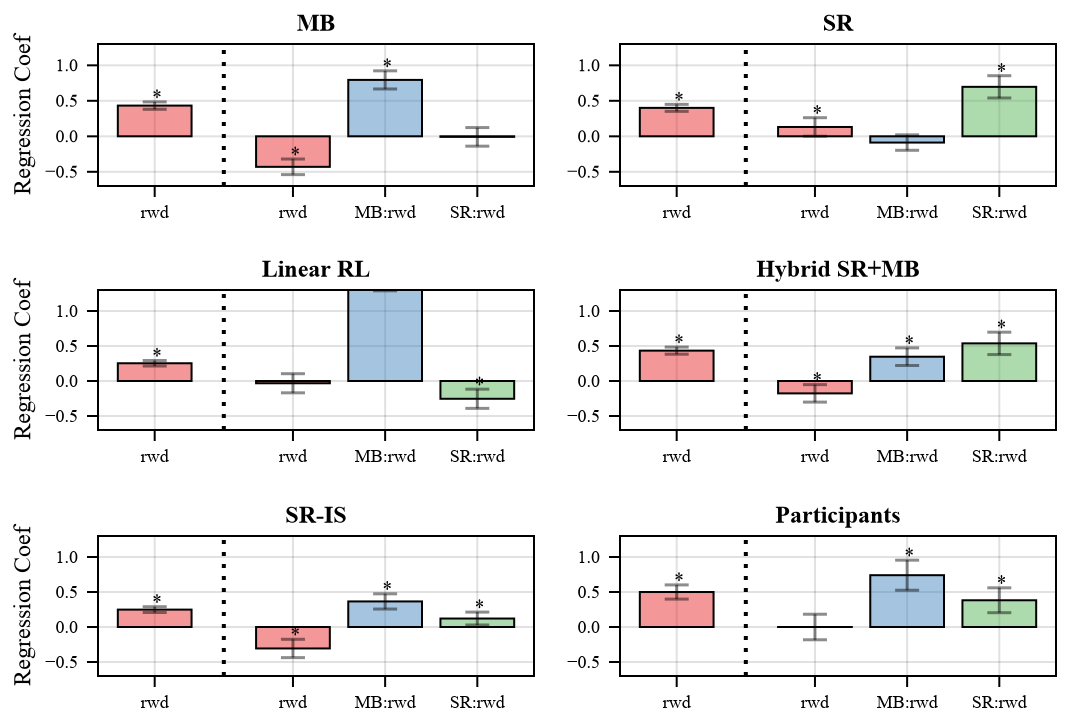

In [20]:
# f = Figure(size=72 .* (6, 3.75))
# set_theme!(fonts = (regular = "Times New Roman", bold = "Times New Roman Bold"))
f = Figure(size=72 .* (7.4, 5), fonts = (regular = "Times New Roman", bold = "Times New Roman Bold"))
colors = categorical_colors(:Set1, 4)
set_theme!(fonts = (regular = "Times New Roman", bold = "Times New Roman Bold"),
           Label = (fontsize = 9,),        # Subplot labels (a, b, c, etc.)
           Axis = (xlabelsize = 12,         # X-axis labels
                   ylabelsize = 12,         # Y-axis labels  
                   xticklabelsize = 9,     # X-tick labels
                   yticklabelsize = 9,     # Y-tick labels
                   titlesize = 12))         # Axis titles

## Plot 1: MB (1,1)
coefs_rwd = coefs_rwd_mb
stderrs_rwd = stderrs_rwd_mb
pvals_rwd = pvals_rwd_mb
coefs_full = coefs_full_mb
stderrs_full = stderrs_full_mb
pvals_full = pvals_full_mb
ax = Axis(f[1,1], xticks = ([1,2.5,3.5,4.5], ["rwd", "rwd", "MB:rwd", "SR:rwd"]),
    ylabel="Regression Coef",
    palette = (; patchcolor = colors),
    # title = "Effect of Sample Reward on Choice, MB",
    title = "MB",
)
# Label(f[1, 1, TopLeft()], "a", fontsize = 9, font = :bold, padding = (0, 12, 2, 0), halign = :right)
ylims!(-0.7, 1.3)
barplot!([1], coefs_rwd, strokecolor = :black, strokewidth = 1, color=(colors[1], 0.45))
errorbars!([1], coefs_rwd, 1.96 .* stderrs_rwd, whiskerwidth = 12.0, color=(:black, 0.45))
barplot!([2.5], [coefs_full[1]], strokecolor = :black, strokewidth = 1, color=(colors[1], 0.45))
barplot!([3.5], [coefs_full[2]], strokecolor = :black, strokewidth = 1, color=(colors[2], 0.45))
barplot!([4.5], [coefs_full[3]], strokecolor = :black, strokewidth = 1, color=(colors[3], 0.45))
errorbars!([2.5, 3.5, 4.5], coefs_full, 1.96 .* stderrs_full, whiskerwidth = 12.0, color=(:black, 0.45))
vlines!(ax, [1.75], color=:black, linewidth=2, linestyle=:dot)
if pvals_rwd[1] < 0.05
    text!(1-0.03, (coefs_rwd .+ 1.96 .* stderrs_rwd)[1] - 0.08; text="*", fontsize=10)
end
for i in 1:3
    if pvals_full[i] < 0.05
        text!(i + 1.5 - 0.03, (coefs_full .+ 1.96 .* stderrs_full)[i] - 0.08; text="*", fontsize=10)
    end
end

## Plot 2: SR (1,2)
coefs_rwd = coefs_rwd_sr
stderrs_rwd = stderrs_rwd_sr
pvals_rwd = pvals_rwd_sr
coefs_full = coefs_full_sr
stderrs_full = stderrs_full_sr
pvals_full = pvals_full_sr
ax = Axis(f[1,2], xticks = ([1,2.5,3.5,4.5], ["rwd", "rwd", "MB:rwd", "SR:rwd"]),
    # ylabel="Regression Coef",
    palette = (; patchcolor = colors),
    # title = "Effect of Sample Reward on Choice, SR",
    title = "SR",
)
# Label(f[1, 2, TopLeft()], "b", fontsize = 9, font = :bold, padding = (0, 12, 2, 0), halign = :right)
ylims!(-0.7, 1.3)
barplot!([1], coefs_rwd, strokecolor = :black, strokewidth = 1, color=(colors[1], 0.45))
errorbars!([1], coefs_rwd, 1.96 .* stderrs_rwd, whiskerwidth = 12.0, color=(:black, 0.45))
barplot!([2.5], [coefs_full[1]], strokecolor = :black, strokewidth = 1, color=(colors[1], 0.45))
barplot!([3.5], [coefs_full[2]], strokecolor = :black, strokewidth = 1, color=(colors[2], 0.45))
barplot!([4.5], [coefs_full[3]], strokecolor = :black, strokewidth = 1, color=(colors[3], 0.45))
errorbars!([2.5, 3.5, 4.5], coefs_full, 1.96 .* stderrs_full, whiskerwidth = 12.0, color=(:black, 0.45))
vlines!(ax, [1.75], color=:black, linewidth=2, linestyle=:dot)
if pvals_rwd[1] < 0.05
    text!(1-0.03, (coefs_rwd .+ 1.96 .* stderrs_rwd)[1] - 0.08; text="*", fontsize=10)
end
for i in 1:3
    if pvals_full[i] < 0.05
        text!(i + 1.5 - 0.03, (coefs_full .+ 1.96 .* stderrs_full)[i] - 0.08; text="*", fontsize=10)
    end
end

## Plot 3: Linear RL (2,1)
coefs_rwd = coefs_rwd_lrl
stderrs_rwd = stderrs_rwd_lrl
pvals_rwd = pvals_rwd_lrl
coefs_full = coefs_full_lrl
stderrs_full = stderrs_full_lrl
pvals_full = pvals_full_lrl
ax = Axis(f[2,1], xticks = ([1,2.5,3.5,4.5], ["rwd", "rwd", "MB:rwd", "SR:rwd"]),
    ylabel="Regression Coef",
    palette = (; patchcolor = colors),
    # title = "Effect of Sample Reward on Choice, Linear RL",
    title = "Linear RL",
)
# Label(f[2, 1, TopLeft()], "c", fontsize = 9, font = :bold, padding = (0, 12, 2, 0), halign = :right)
ylims!(-0.7, 1.3)
barplot!([1], coefs_rwd, strokecolor = :black, strokewidth = 1, color=(colors[1], 0.45))
errorbars!([1], coefs_rwd, 1.96 .* stderrs_rwd, whiskerwidth = 12.0, color=(:black, 0.45))
barplot!([2.5], [coefs_full[1]], strokecolor = :black, strokewidth = 1, color=(colors[1], 0.45))
barplot!([3.5], [coefs_full[2]], strokecolor = :black, strokewidth = 1, color=(colors[2], 0.45))
barplot!([4.5], [coefs_full[3]], strokecolor = :black, strokewidth = 1, color=(colors[3], 0.45))
errorbars!([2.5, 3.5, 4.5], coefs_full, 1.96 .* stderrs_full, whiskerwidth = 12.0, color=(:black, 0.45))
vlines!(ax, [1.75], color=:black, linewidth=2, linestyle=:dot)
if pvals_rwd[1] < 0.05
    text!(1-0.03, (coefs_rwd .+ 1.96 .* stderrs_rwd)[1] - 0.08; text="*", fontsize=10)
end
for i in 1:3
    if pvals_full[i] < 0.05
        text!(i + 1.5 - 0.03, (coefs_full .+ 1.96 .* stderrs_full)[i] - 0.08; text="*", fontsize=10)
    end
end

## Plot 4: SR/MB Hybrid (2,2)
coefs_rwd = coefs_rwd_mb_sr
stderrs_rwd = stderrs_rwd_mb_sr
pvals_rwd = pvals_rwd_mb_sr
coefs_full = coefs_full_mb_sr
stderrs_full = stderrs_full_mb_sr
pvals_full = pvals_full_mb_sr
ax = Axis(f[2,2], xticks = ([1,2.5,3.5,4.5], ["rwd", "rwd", "MB:rwd", "SR:rwd"]),
    # ylabel="Regression Coef",
    palette = (; patchcolor = colors),
    # title = "Effect of Sample Reward on Choice, SR+MB Hybrid",
    title = "Hybrid SR+MB",
)
# Label(f[2, 2, TopLeft()], "d", fontsize = 9, font = :bold, padding = (0, 12, 2, 0), halign = :right)
ylims!(-0.7, 1.3)
barplot!([1], coefs_rwd, strokecolor = :black, strokewidth = 1, color=(colors[1], 0.45))
errorbars!([1], coefs_rwd, 1.96 .* stderrs_rwd, whiskerwidth = 12.0, color=(:black, 0.45))
barplot!([2.5], [coefs_full[1]], strokecolor = :black, strokewidth = 1, color=(colors[1], 0.45))
barplot!([3.5], [coefs_full[2]], strokecolor = :black, strokewidth = 1, color=(colors[2], 0.45))
barplot!([4.5], [coefs_full[3]], strokecolor = :black, strokewidth = 1, color=(colors[3], 0.45))
errorbars!([2.5, 3.5, 4.5], coefs_full, 1.96 .* stderrs_full, whiskerwidth = 12.0, color=(:black, 0.45))
vlines!(ax, [1.75], color=:black, linewidth=2, linestyle=:dot)
if pvals_rwd[1] < 0.05
    text!(1-0.03, (coefs_rwd .+ 1.96 .* stderrs_rwd)[1] - 0.08; text="*", fontsize=10)
end
for i in 1:3
    if pvals_full[i] < 0.05
        text!(i + 1.5 - 0.03, (coefs_full .+ 1.96 .* stderrs_full)[i] - 0.08; text="*", fontsize=10)
    end
end

## Plot 5: SR-IS (3,1)
coefs_rwd = coefs_rwd_sr_is
stderrs_rwd = stderrs_rwd_sr_is
pvals_rwd = pvals_rwd_sr_is
coefs_full = coefs_full_sr_is
stderrs_full = stderrs_full_sr_is
pvals_full = pvals_full_sr_is
ax = Axis(f[3,1], xticks = ([1,2.5,3.5,4.5], ["rwd", "rwd", "MB:rwd", "SR:rwd"]),
    ylabel="Regression Coef",
    palette = (; patchcolor = colors),
    # title = "Effect of Sample Reward on Choice, SR-IS",
    title = "SR-IS",
)
# Label(f[3, 1, TopLeft()], "e", fontsize = 9, font = :bold, padding = (0, 12, 2, 0), halign = :right)
ylims!(-0.7, 1.3)
barplot!([1], coefs_rwd, strokecolor = :black, strokewidth = 1, color=(colors[1], 0.45))
errorbars!([1], coefs_rwd, 1.96 .* stderrs_rwd, whiskerwidth = 12.0, color=(:black, 0.45))
barplot!([2.5], [coefs_full[1]], strokecolor = :black, strokewidth = 1, color=(colors[1], 0.45))
barplot!([3.5], [coefs_full[2]], strokecolor = :black, strokewidth = 1, color=(colors[2], 0.45))
barplot!([4.5], [coefs_full[3]], strokecolor = :black, strokewidth = 1, color=(colors[3], 0.45))
errorbars!([2.5, 3.5, 4.5], coefs_full, 1.96 .* stderrs_full, whiskerwidth = 12.0, color=(:black, 0.45))
vlines!(ax, [1.75], color=:black, linewidth=2, linestyle=:dot)
if pvals_rwd[1] < 0.05
    text!(1-0.03, (coefs_rwd .+ 1.96 .* stderrs_rwd)[1] - 0.08; text="*", fontsize=10)
end
for i in 1:3
    if pvals_full[i] < 0.05
        text!(i + 1.5 - 0.03, (coefs_full .+ 1.96 .* stderrs_full)[i] - 0.08; text="*", fontsize=10)
    end
end

## Plot 6: Participants (3,2)
coefs_rwd = coefs_rwd_participants
stderrs_rwd = stderrs_rwd_participants
pvals_rwd = pvals_rwd_participants
coefs_full = coefs_full_participants
stderrs_full = stderrs_full_participants
pvals_full = pvals_full_participants
ax = Axis(f[3,2], xticks = ([1,2.5,3.5,4.5], ["rwd", "rwd", "MB:rwd", "SR:rwd"]),
    # ylabel="Regression Coef",
    palette = (; patchcolor = colors),
    # title = "Effect of Sample Reward on Choice, Participants",
    title = "Participants",
)
# Label(f[3, 2, TopLeft()], "f", fontsize = 9, font = :bold, padding = (0, 12, 2, 0), halign = :right)
ylims!(-0.7, 1.3)
barplot!([1], coefs_rwd, strokecolor = :black, strokewidth = 1, color=(colors[1], 0.45))
errorbars!([1], coefs_rwd, 1.96 .* stderrs_rwd, whiskerwidth = 12.0, color=(:black, 0.45))
barplot!([2.5], [coefs_full[1]], strokecolor = :black, strokewidth = 1, color=(colors[1], 0.45))
barplot!([3.5], [coefs_full[2]], strokecolor = :black, strokewidth = 1, color=(colors[2], 0.45))
barplot!([4.5], [coefs_full[3]], strokecolor = :black, strokewidth = 1, color=(colors[3], 0.45))
errorbars!([2.5, 3.5, 4.5], coefs_full, 1.96 .* stderrs_full, whiskerwidth = 12.0, color=(:black, 0.45))
vlines!(ax, [1.75], color=:black, linewidth=2, linestyle=:dot)
if pvals_rwd[1] < 0.05
    text!(1-0.03, (coefs_rwd .+ 1.96 .* stderrs_rwd)[1] - 0.08; text="*", fontsize=10)
end
for i in 1:3
    if pvals_full[i] < 0.05
        text!(i + 1.5 - 0.03, (coefs_full .+ 1.96 .* stderrs_full)[i] - 0.08; text="*", fontsize=10)
    end
end

save("../figures/Final_V3.pdf", f, pt_per_unit=1)
f

In [ ]:
coefs_full_participants, stderrs_full_participants
coefs_full_mb_sr, stderrs_full_mb_sr
coefs_full_sr_is, stderrs_full_sr_is

3-element Vector{Float64}:
 -0.3065338649341993
  0.36530964223824075
  0.12104274153724409

In [ ]:
function ind_test(coef1, coef2, se1, se2)
    diff = coef1 - coef2
    se_diff = sqrt(se1^2 + se2^2)

    z_stat = diff/se_diff
    p_val = 2 * (1 - cdf(Normal(), abs(z_stat)))

    return (difference = diff, se_difference = se_diff, z_statistic = z_stat, p_value = p_val)
end

function paired_t_test(coef1, coef2)
    # Calculate paired differences
    diff = coef1 - coef2
    
    # Basic statistics
    n = length(diff)
    mean_diff = mean(diff)
    se_diff = std(diff) / sqrt(n)
    
    # t-statistic and p-value
    t_stat = mean_diff / se_diff
    df = n - 1
    p_val = 2 * (1 - cdf(TDist(df), abs(t_stat)))
    
    return (mean_difference = mean_diff, t_statistic = t_stat, p_value = p_val)
end


paired_t_test (generic function with 1 method)

In [ ]:
diff_part, se_part, z_part, p_part = ind_test(coefs_full_participants[2], coefs_full_participants[3], stderrs_full_participants[2], stderrs_full_participants[3])

(difference = 0.3581574480342058, se_difference = 0.14236332381928019, z_statistic = 2.515798580882113, p_value = 0.01187630333345524)

In [ ]:
diff_mbsr, se_mbsr, z_mbsr, p_mbsr = ind_test(coefs_full_mb_sr[2], coefs_full_mb_sr[3], stderrs_full_mb_sr[2], stderrs_full_mb_sr[3])

(difference = -0.19081121533707257, se_difference = 0.10385018507969976, z_statistic = -1.8373700074837096, p_value = 0.06615529136611942)

In [ ]:
diff_sris, se_sris, z_sris, p_sris = ind_test(coefs_full_sr_is[2], coefs_full_sr_is[3], stderrs_full_sr_is[2], stderrs_full_sr_is[3])

(difference = 0.24426690070099666, se_difference = 0.07269709638097813, z_statistic = 3.360064058416938, p_value = 0.0007792440227167852)

In [ ]:
diff_mbsr, t_mbsr, p_mbsr = paired_t_test([coefs_full_mb_sr[2], coefs_full_mb_sr[3]], [coefs_full_participants[2], coefs_full_participants[3]])

(mean_difference = -0.11858485833185656, t_statistic = -0.432027786808863, p_value = 0.7403812651098294)

In [ ]:
diff_sris, t_sris, p_sris = paired_t_test([coefs_full_sr_is[2], coefs_full_sr_is[3]], [coefs_full_participants[2], coefs_full_participants[3]])

(mean_difference = -0.3177407378891336, t_statistic = -5.579756096166975, p_value = 0.11289601104307145)